In [1]:
%load_ext autoreload
%autoreload 2

# Wind-up example using SMARTEOLE dataset

Dataset citation:
Thomas Duc, & Eric Simley. (2022): [SMARTEOLE Wind Farm Control open dataset (1.0)](https://doi.org/10.5281/zenodo.7342466)

See the [wind-up uplift validation methodology](https://github.com/resgroup/wind-up/blob/main/docs/wind-up%20uplift%20validation%20methodology%20v3.pdf) for a description of the calculation methodology.

In [2]:
import logging

from helpers import setup_logger

import wind_up

setup_logger()


logger = logging.getLogger(__name__)
msg = f"wind-up version: {wind_up.__version__}"
logger.info(msg)

wind-up version: 0.4.5


## 1. downloading the open dataset

In [3]:
from helpers import download_zenodo_data

from wind_up.constants import OUTPUT_DIR, PROJECTROOT_DIR

filename = "SMARTEOLE-WFC-open-dataset.zip"
outpur_dir = PROJECTROOT_DIR / "tests" / "test_data" / "smarteole"

download_zenodo_data(
    record_id="7342466",
    output_dir=outpur_dir,
    filenames=[filename],
    cache_overwrite=False,  # change to True if you want to force the re-download
)

All filenames are locally cached, no download necessary.


## 2. extracting and format the data

In [4]:
from smarteole_utils import SmartEoleExtractor

analysis_timebase_s = 600

extractor = SmartEoleExtractor.from_zip_file(
    zipped_fpath=outpur_dir / filename,
    analysis_timebase_s=analysis_timebase_s,
)

#### 2.1 scada data

In [5]:
scada_df = extractor.unpack_smarteole_scada()
scada_df.head(3)

TurbineName  ActivePowerMean  ActivePowerSD  \
TimeStamp_StartFormat                                               
2020-02-17 16:30:00          SMV1        2017.8566        57.0837   
2020-02-17 16:40:00          SMV1        1946.2472        91.7614   
2020-02-17 16:50:00          SMV1        1946.5069        98.3934   

                       WindSpeedMean  WindSpeedSD  YawAngleMean  YawAngleMin  \
TimeStamp_StartFormat                                                          
2020-02-17 16:30:00          13.6164       1.2411    247.884662      239.930   
2020-02-17 16:40:00          13.0139       1.0178    259.686000      259.686   
2020-02-17 16:50:00          12.5818       0.9482    259.686000      259.686   

                       YawAngleMax  PitchAngleMean  GenRpmMean  AmbientTemp  \
TimeStamp_StartFormat                                                         
2020-02-17 16:30:00        259.686          6.0648   1800.5394      11.6191   
2020-02-17 16:40:00        259.686          3.5153   1798.7652      11.5493   
2020-02-17 16:50:00        259.686          2.1367   1799.5171      11.4929   

                       ShutdownDuration  
TimeStamp_StartFormat                    
2020-02-17 16:30:00                   0  
2020-02-17 16:40:00                   0  
2020-02-17 16:50:00                   0

#### 2.2 metadata

In [6]:
metadata_df = extractor.unpack_smarteole_metadata()
metadata_df.head(3)

Name  Latitude  Longitude TimeZone  TimeSpanMinutes TimeFormat
0  SMV1  49.84975    2.80194      UTC             10.0      Start
1  SMV2  49.84661    2.80150      UTC             10.0      Start
2  SMV3  49.84347    2.80162      UTC             10.0      Start

#### 2.3 toggle data
toggle data is data from the controller running the toggle test, in this case a wake steering controller

In [7]:
toggle_df = extractor.unpack_smarteole_toggle_data()
toggle_df[toggle_df["yaw_offset_command"] > 10].head(3)  # noqa: PLR2004

toggle_on  toggle_off  yaw_offset_command
TimeStamp_StartFormat                                               
2020-02-18 07:00:00+00:00       True       False             10.1839
2020-02-18 07:30:00+00:00       True       False             10.4246
2020-02-18 07:40:00+00:00       True       False             10.9057

## 3. Get reference data
We'll use nearby ERA5 re-analysis data, previously downloaded

In [8]:
import pandas as pd

from wind_up.reanalysis_data import ReanalysisDataset

reanalysis_dataset = ReanalysisDataset(
    id="ERA5T_50.00N_2.75E_100m_1hr",
    data=pd.read_parquet(
        PROJECTROOT_DIR / "tests/test_data/smarteole/ERA5T_50.00N_2.75E_100m_1hr_20200201_20200531.parquet"
    ),
)
reanalysis_dataset.data.head(3)

10_m_hws_mean_mps  10_m_hwd_mean_deg-n_true  \
datetime_start_utc                                                       
2020-02-01 00:00:00+00:00               6.29                     203.1   
2020-02-01 01:00:00+00:00               6.57                     204.3   
2020-02-01 02:00:00+00:00               6.54                     209.5   

                           100_m_hws_mean_mps  100_m_hwd_mean_deg-n_true  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00               10.33                      206.6   
2020-02-01 01:00:00+00:00               10.80                      207.4   
2020-02-01 02:00:00+00:00               10.69                      212.1   

                           2_m_temp_mean_deg-c  2_m_dew_point_temp_deg-c  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00                 11.6                       9.8   
2020-02-01 01:00:00+00:00                 11.6                      10.2   
2020-02-01 02:00:00+00:00                 11.6                      10.7   

                           2_m_rh_mean_%  0_m_pres_mean_pa  \
datetime_start_utc                                           
2020-02-01 00:00:00+00:00           88.9           99621.8   
2020-02-01 01:00:00+00:00           91.2           99547.5   
2020-02-01 02:00:00+00:00           93.9           99486.1   

                           sea_level_pres_mean_pa  boundary_layer_height_m  \
datetime_start_utc                                                           
2020-02-01 00:00:00+00:00                100815.6                    834.2   
2020-02-01 01:00:00+00:00                100739.8                    813.0   
2020-02-01 02:00:00+00:00                100678.0                    808.8   

                           total_cloud_cover_%  \
datetime_start_utc                               
2020-02-01 00:00:00+00:00                100.0   
2020-02-01 01:00:00+00:00                100.0   
2020-02-01 02:00:00+00:00                100.0   

                           instantaneous_surface_sensible_heat_flux_wpm2  \
datetime_start_utc                                                         
2020-02-01 00:00:00+00:00                                         30.138   
2020-02-01 01:00:00+00:00                                         33.538   
2020-02-01 02:00:00+00:00                                         32.996   

                           friction_velocity_mps  cloud_base_height_m  \
datetime_start_utc                                                      
2020-02-01 00:00:00+00:00               0.441049                204.6   
2020-02-01 01:00:00+00:00               0.435240                 30.8   
2020-02-01 02:00:00+00:00               0.424339                 30.8   

                           surface_solar_radiation_downwards_wpm2  era5t  
datetime_start_utc                                                        
2020-02-01 00:00:00+00:00                                     0.0      0  
2020-02-01 01:00:00+00:00                                     0.0      0  
2020-02-01 02:00:00+00:00                                     0.0      0

## 4. Define the assessment configuration

In [9]:
from wind_up.models import Asset, PlotConfig, Toggle, Turbine, WindUpConfig

#### 4.1 defining the turbine information

In [10]:
wtg_map = {
    f"SMV{i}": Turbine.model_validate(
        {
            "name": f"SMV{i}",
            "turbine_type": {
                "turbine_type": "Senvion-MM82-2050",
                "rotor_diameter_m": 82.0,
                "rated_power_kw": 2050.0,
                "normal_operation_pitch_range": (-10.0, 35.0),
                "normal_operation_genrpm_range": (250.0, 2000.0),
            },
        }
    )
    for i in range(1, 7 + 1)
}

#### 4.2 defining northing corrections
Northing corrections are defined by running the analysis with `WindUpConfig.optimize_northing_corrections` set to `True`. The northing correction calculation is time consuming; it is generally acceptable to run it one time on a particular dataset and then preserve the result as config thereafter.

In [11]:
northing_corrections_utc = [
    ("SMV1", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.750994540354649),
    ("SMV2", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.690999999999994),
    ("SMV3", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.558000000000042),
    ("SMV4", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.936999999999996),
    ("SMV5", pd.Timestamp("2020-02-17 16:30:00+0000"), 6.797253350869262),
    ("SMV6", pd.Timestamp("2020-02-17 16:30:00+0000"), 5.030130916842758),
    ("SMV7", pd.Timestamp("2020-02-17 16:30:00+0000"), 4.605999999999972),
]

#### 4.3 defining the WindUp and Plot configurations

In [12]:
analysis_output_dir = OUTPUT_DIR / "smarteole_example"

# allowing bigger margin if analysing at lower frequency
wd_filter_margin = 3 + 7 * analysis_timebase_s / 600

cfg = WindUpConfig(
    assessment_name="smarteole_example",
    timebase_s=analysis_timebase_s,
    require_ref_wake_free=True,
    detrend_min_hours=12,  # shorter than the default of 24 because this dataset is small
    ref_wd_filter=[207 - wd_filter_margin, 236 + wd_filter_margin],  # steer is from 207-236
    filter_all_test_wtgs_together=True,
    use_lt_distribution=False,
    out_dir=analysis_output_dir,
    test_wtgs=[wtg_map["SMV6"], wtg_map["SMV5"]],
    ref_wtgs=[wtg_map["SMV7"]],
    ref_super_wtgs=[],
    non_wtg_ref_names=[],
    analysis_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
    upgrade_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
    analysis_last_dt_utc_start=pd.Timestamp("2020-05-25 00:00:00+0000") - pd.Timedelta(seconds=analysis_timebase_s),
    lt_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
    lt_last_dt_utc_start=pd.Timestamp("2020-05-25 00:00:00+0000") - pd.Timedelta(seconds=analysis_timebase_s),
    detrend_first_dt_utc_start=pd.Timestamp("2020-02-17 16:30:00+0000"),
    detrend_last_dt_utc_start=pd.Timestamp("2020-05-25 00:00:00+0000") - pd.Timedelta(seconds=analysis_timebase_s),
    years_for_lt_distribution=0,
    years_for_detrend=0,
    ws_bin_width=1.0,
    use_test_wtg_lt_distribution=True,  # True for wake steering because uplift is expected to be different per turbine
    asset=Asset(name="Sole du Moulin Vieux", wtgs=list(wtg_map.values()), masts_and_lidars=[]),
    northing_corrections_utc=northing_corrections_utc,
    toggle=Toggle(
        name="wake steering",
        toggle_file_per_turbine=False,
        toggle_filename="SMV_offset_active_toggle_df.parquet",
        detrend_data_selection="use_toggle_off_data",
        pairing_filter_method="any_within_timedelta",
        pairing_filter_timedelta_seconds=3600,
        toggle_change_settling_filter_seconds=120,
    ),
)

plot_cfg = PlotConfig(show_plots=True, save_plots=False, skip_per_turbine_plots=True, plots_dir=cfg.out_dir / "plots")

loaded WindUpConfig assessment_name: smarteole_example
toggle analysis period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00
long term period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00
detrend period (UTC): 2020-02-17 16:30 to 2020-05-25 00:00


#### 4.3 combining all configurations into the assessment inputs object
This object bundles everything needed to run the wind-up analysis
In particular the wind farm SCADA data is filtered and northed.

A wind speed estimate for each turbine is also derived mainly from power so that the anemometer data is used as little as possible.  

running wind_up analysis for smarteole_example
running load_smart_scada_and_md_from_file for 2020-02-17 16:30:00+00:00 to 2020-05-24 23:50:00+00:00
loaded 7 turbines, 0.3 years per turbine
finished load_smart_scada_and_md for 2020-02-17 16:30:00+00:00 to 2020-05-24 23:50:00+00:00


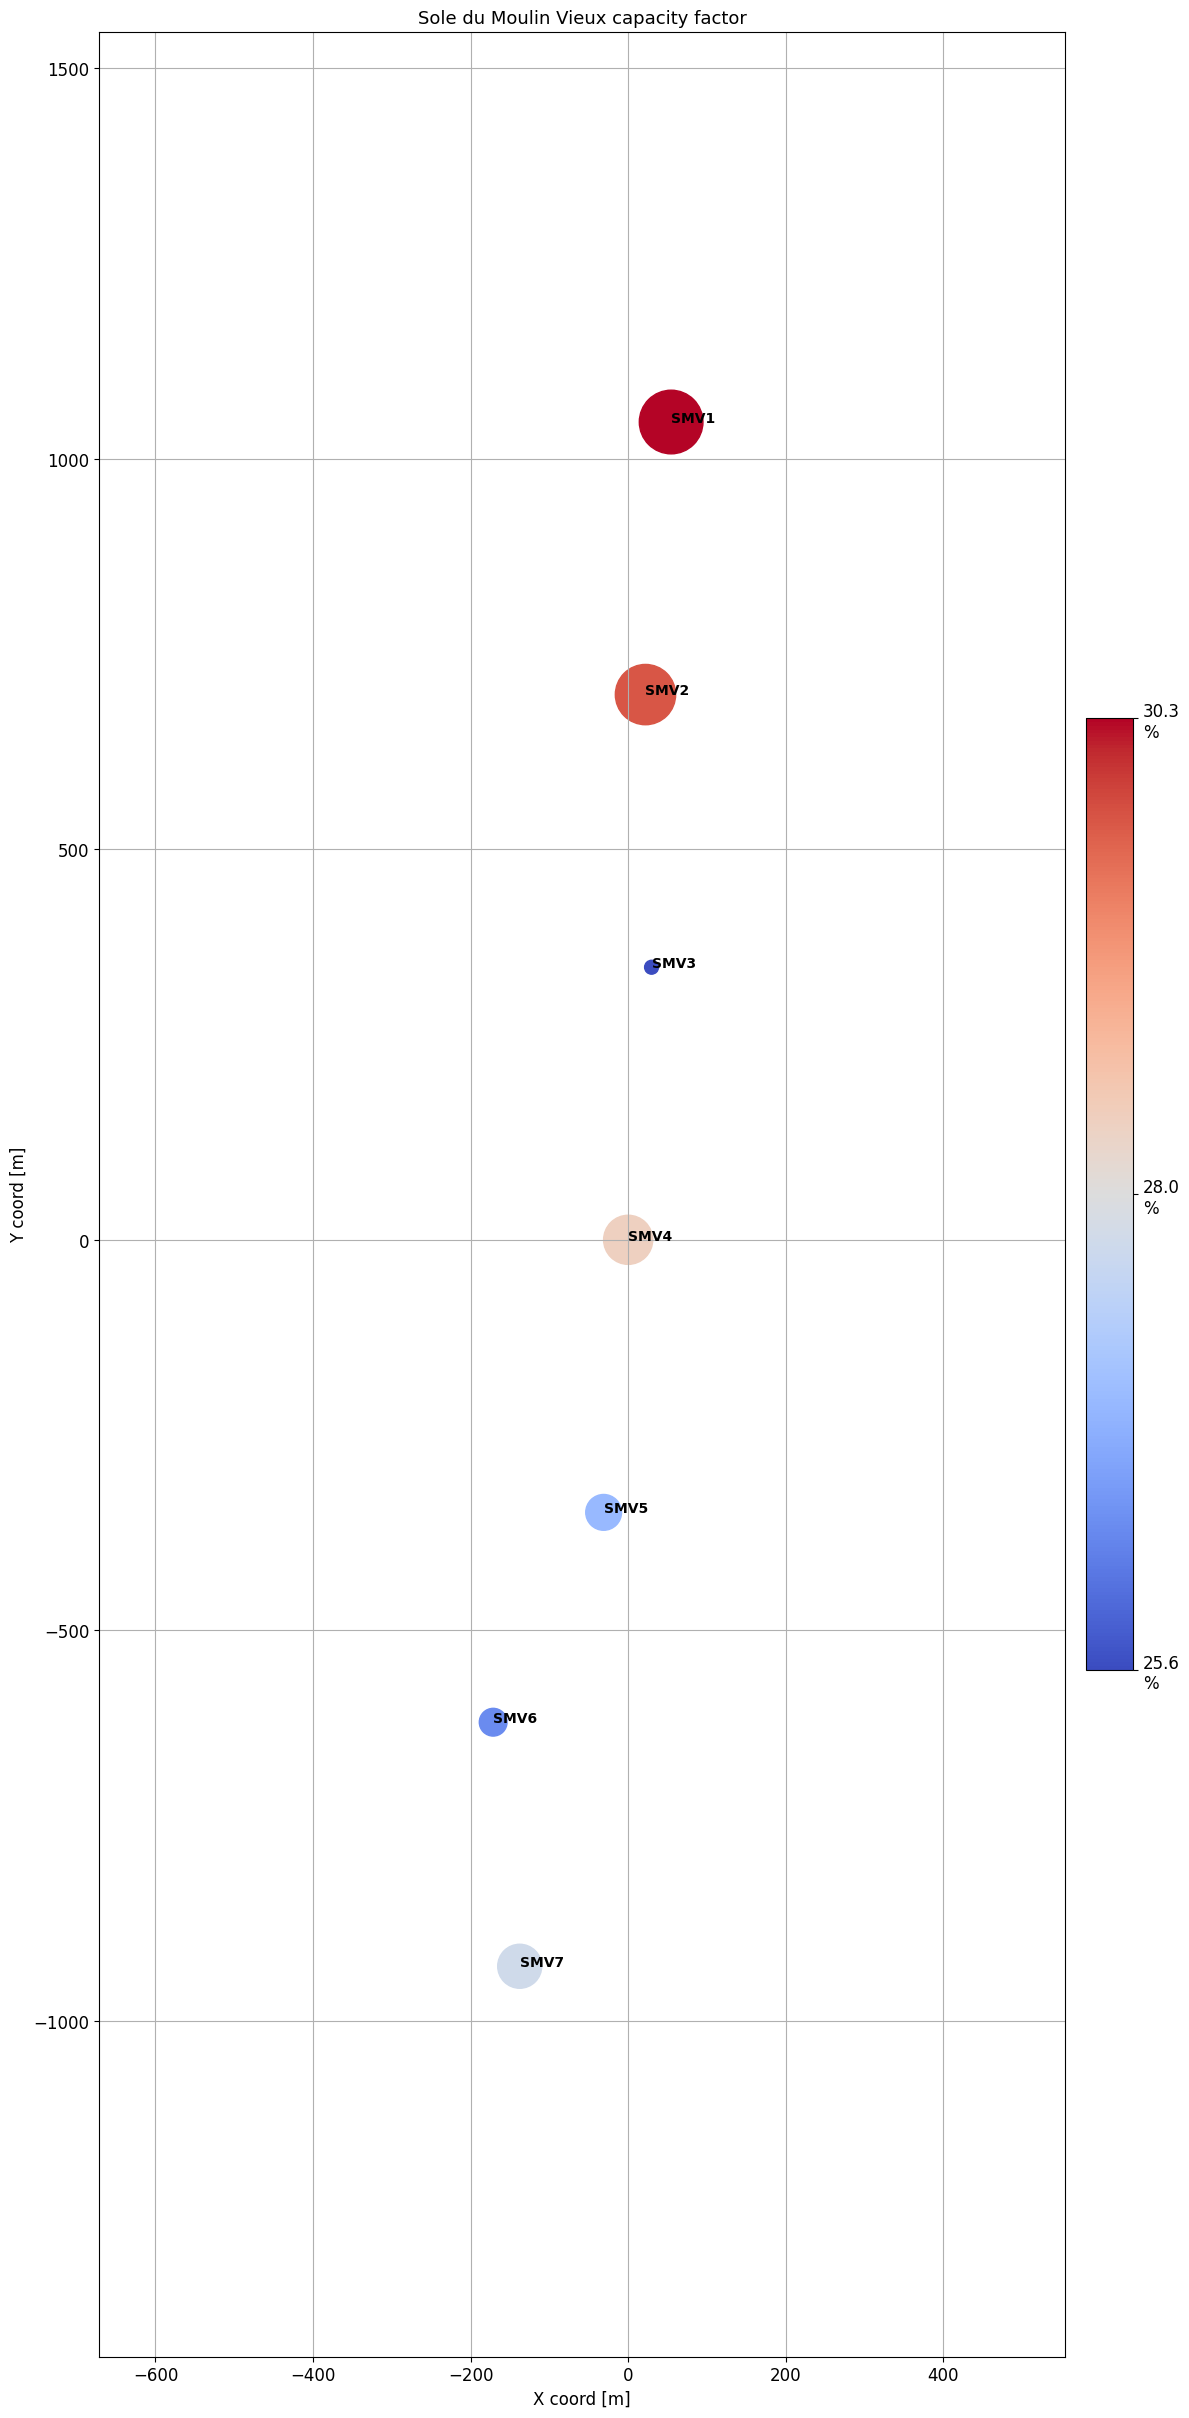

average capacity factor: 27.9%
top 3 capacity factor [%]:
+------+------+
| SMV1 | 30.3 |
| SMV2 | 29.8 |
| SMV4 | 28.3 |
+------+------+
bottom 3 capacity factor [%]:
+------+------+
| SMV3 | 25.6 |
| SMV6 | 26.3 |
| SMV5 | 26.9 |
+------+------+


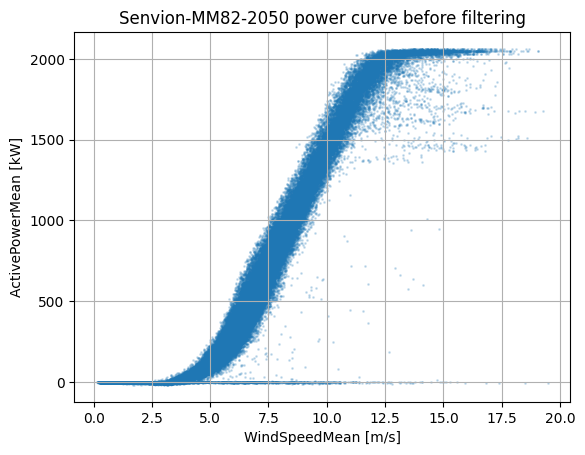

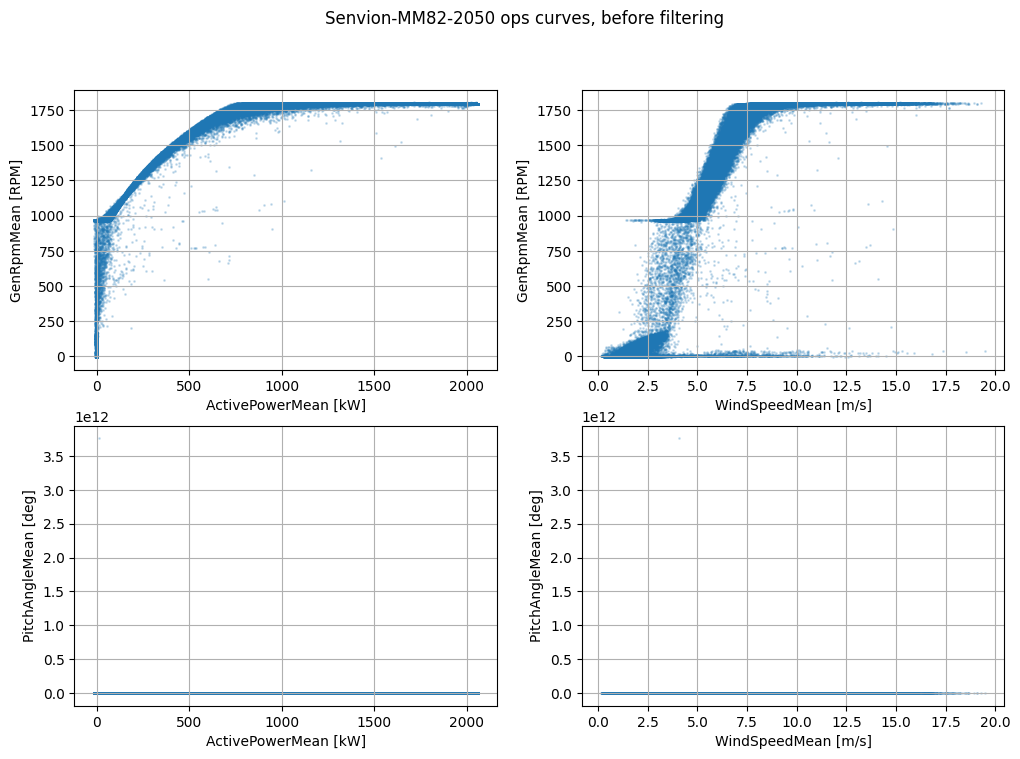

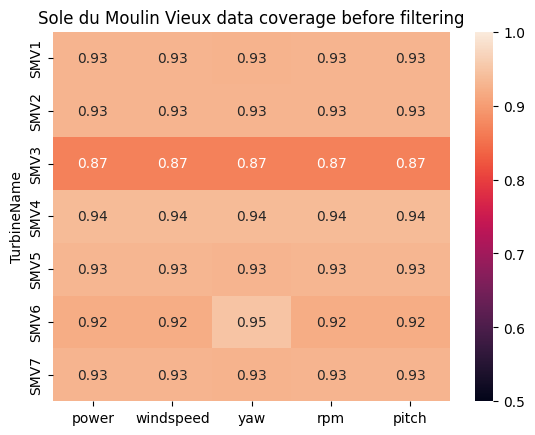

7855 rows [8.0%] of power data is missing before filtering
filter_stuck_data set 7443 rows [7.6%] to NA
filter_bad_pw_ws set 0 rows [0.0%] to NA
rows with PitchAngleMean lt -180: 0
rows with PitchAngleMean ge 180: 1
wrapped PitchAngleMean to -180-180
filter_wrong_yaw set 22829 rows [23.3%] to NA yaw Min & Max because of bad YawAngleMin/Max values
filter_wrong_yaw set 232 rows [0.2%] to NA yaw because of YawAngleMean appears to be wrong
filter_exclusions set 0 rows [0.0%] to NA
filter_yaw_exclusions set 0 rows [0.0%] to NA yaw
filter_downtime set 0 rows [0.0%] to NA


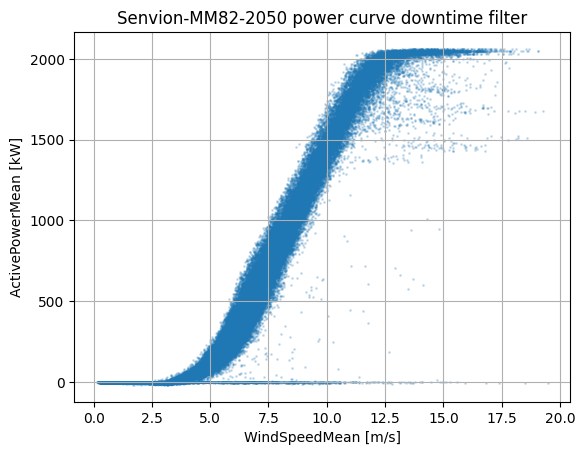

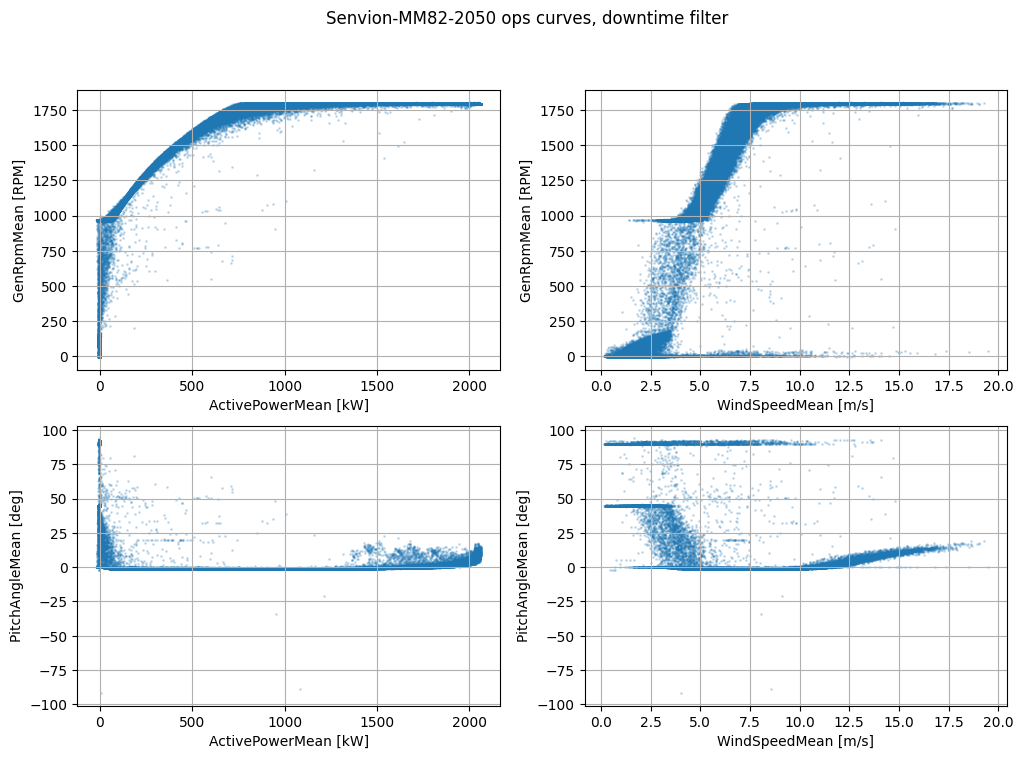

filter_missing_rpm_and_pt set 0 rows [0.0%] to NA because of rpm or pitch are NA
filter_rpm_and_pt set 13598 rows [13.9%] to NA because of rpm or pitch are out of range


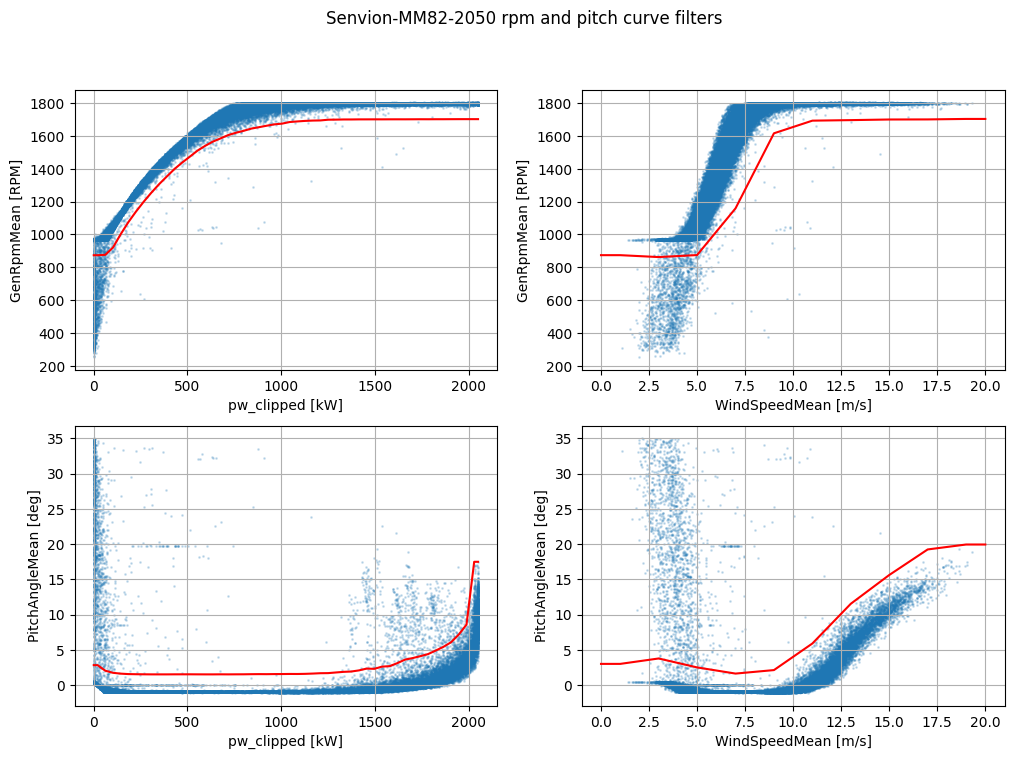

filter_rpm_and_pt set 2663 rows [2.7%] to NA because of rpm or pitch curve filtering


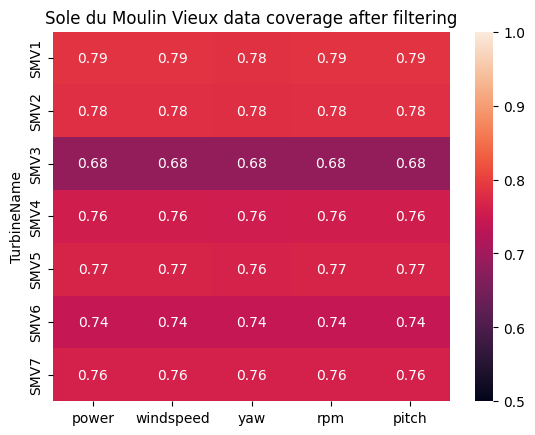

24116 rows [24.6%] of power data is missing after filtering


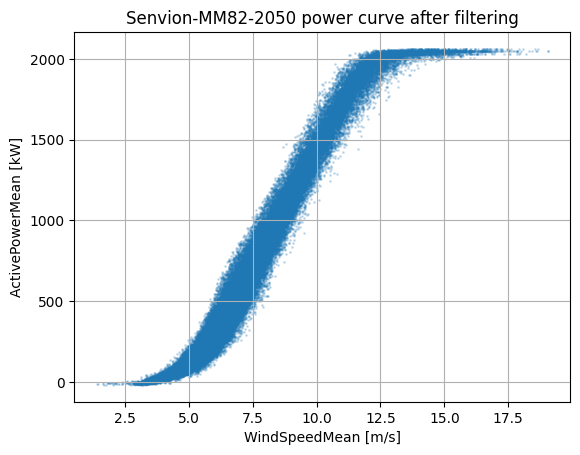

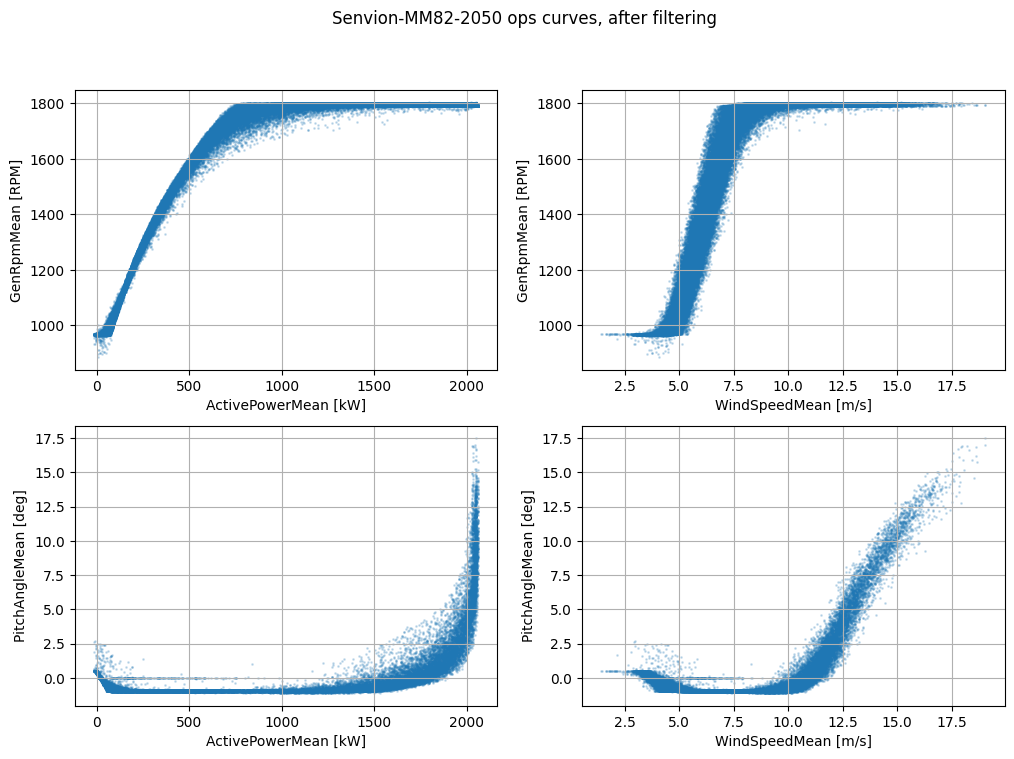

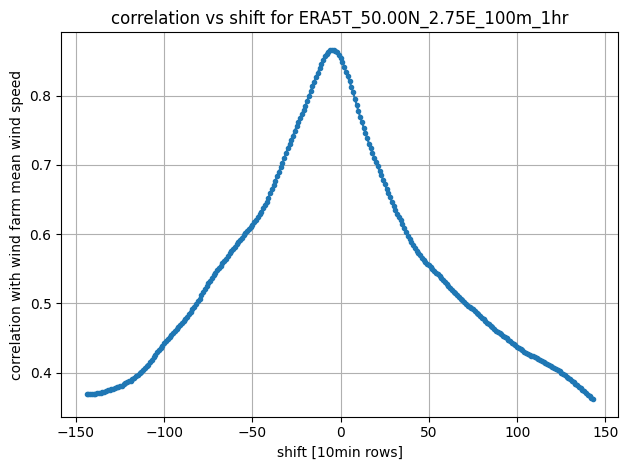

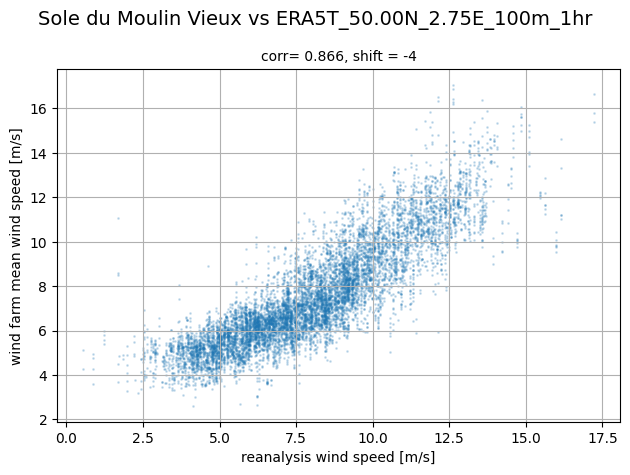

ERA5T_50.00N_2.75E_100m_1hr best correlation is 0.866200 with a shift of -4
ERA5T_50.00N_2.75E_100m_1hr has best correlation: 0.866 with a shift of -4


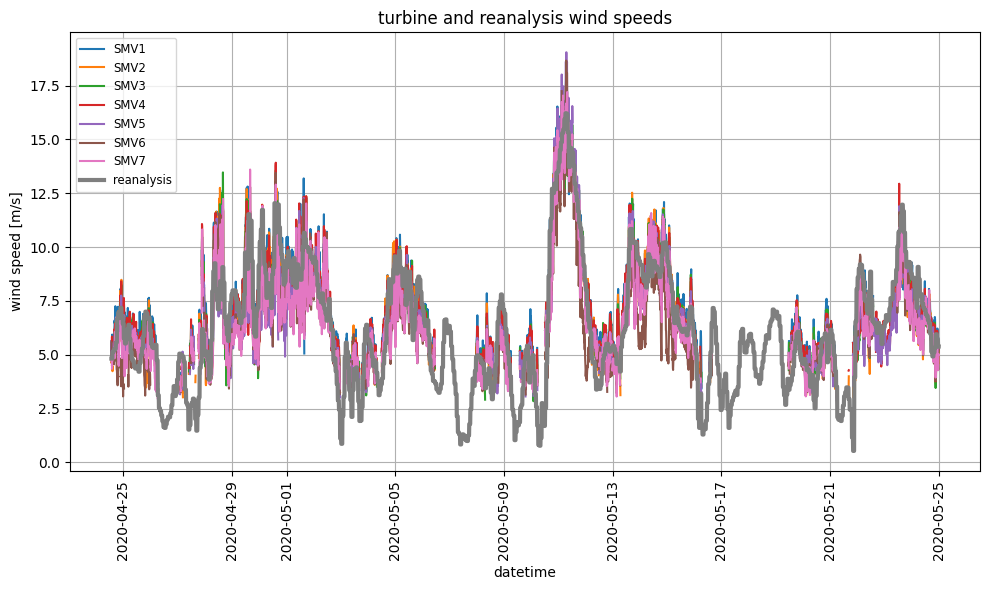

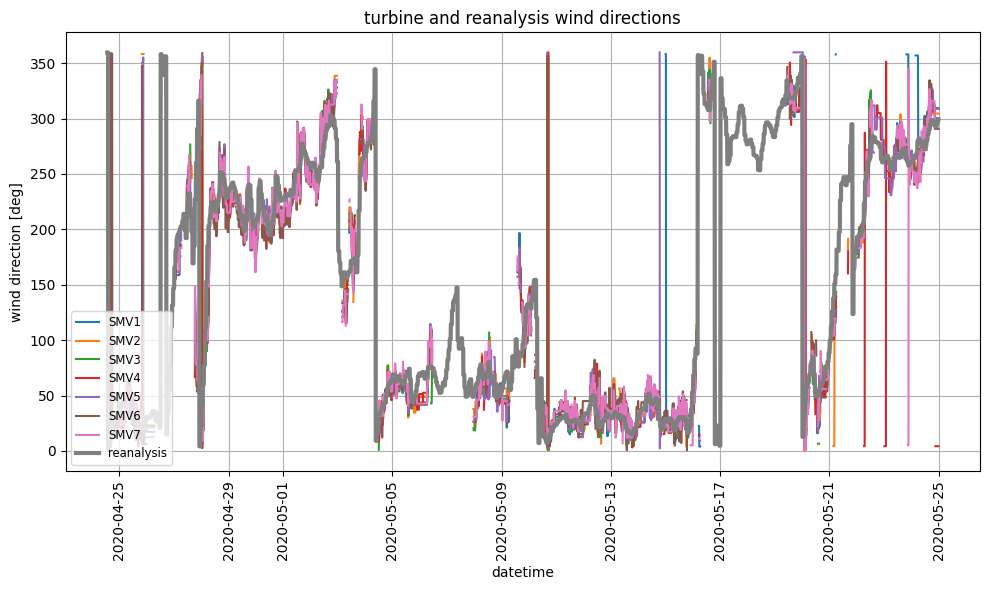

top 3 turbines needing northing correction vs reanalysis_wd before northing:
+------+------+
| SMV6 | 11.6 |
| SMV5 | 11.2 |
| SMV3 | 10.3 |
+------+------+
top 3 REFERENCE turbines needing northing correction vs reanalysis_wd before northing:
+------+-----+
| SMV7 | 8.1 |
+------+-----+


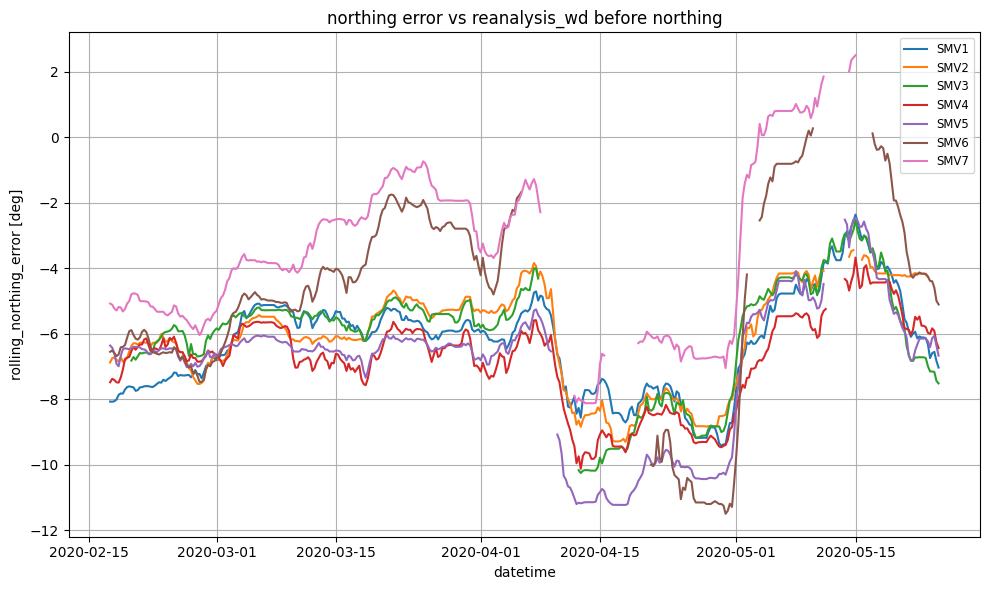

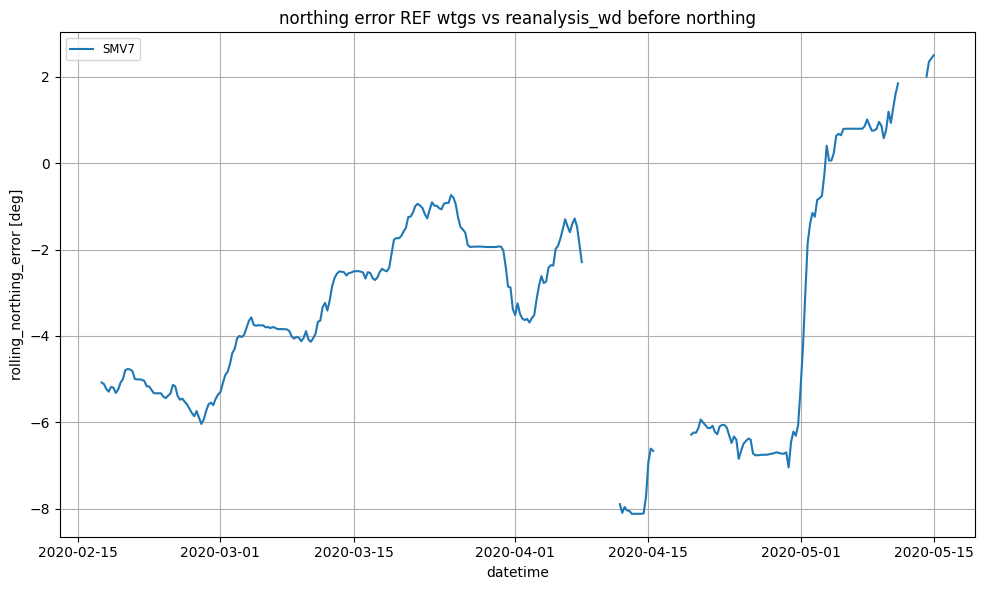

applied 7 northing corrections
top 3 turbines needing northing correction vs reanalysis_wd after northing:
+------+-----+
| SMV7 | 7.1 |
| SMV6 | 6.6 |
| SMV3 | 4.7 |
+------+-----+
top 3 REFERENCE turbines needing northing correction vs reanalysis_wd after northing:
+------+-----+
| SMV7 | 7.1 |
+------+-----+


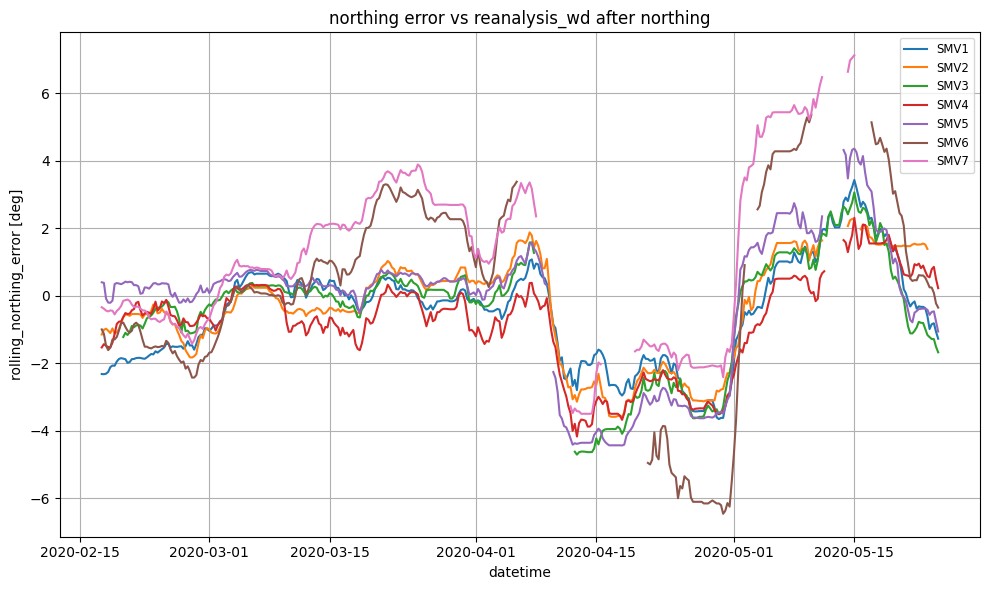

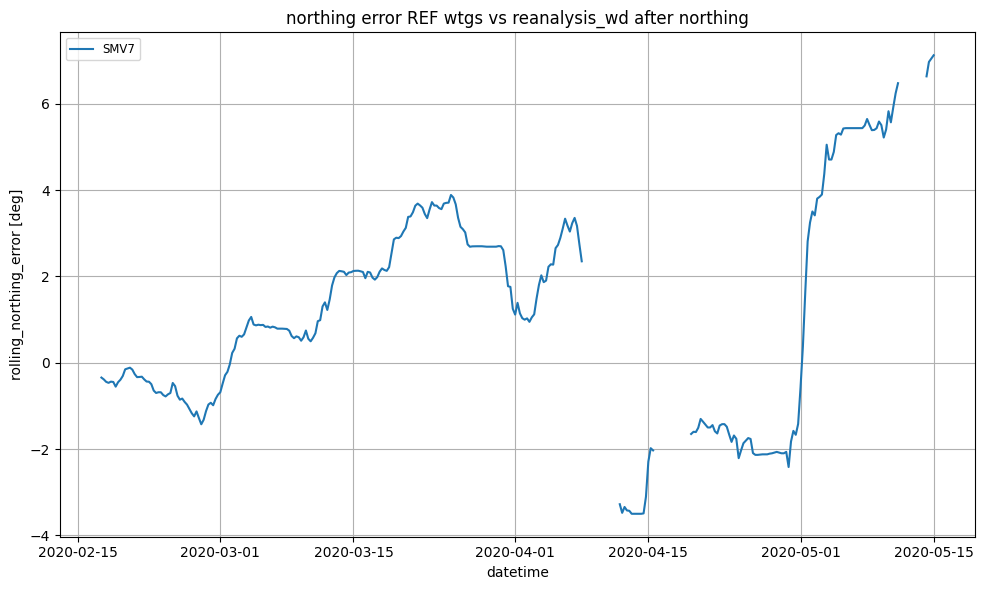

estimated rated wind speed = 14.2 m/s
estimated cut-in wind speed = 3.3 m/s


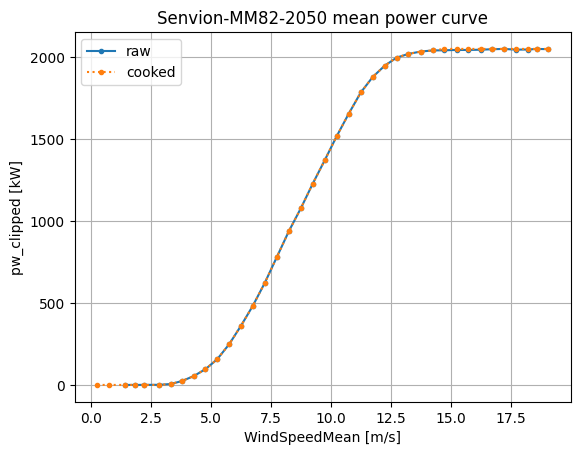

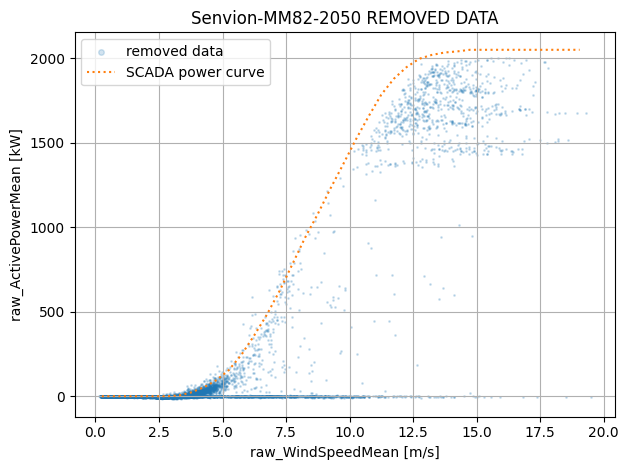

##############################################################################
# estimate wind speed from power
##############################################################################
SMV1 cp correction factor = 0.97
SMV2 cp correction factor = 0.99
SMV3 cp correction factor = 1.00
SMV4 cp correction factor = 0.98
SMV5 cp correction factor = 1.02
SMV6 cp correction factor = 1.03
SMV7 cp correction factor = 1.02


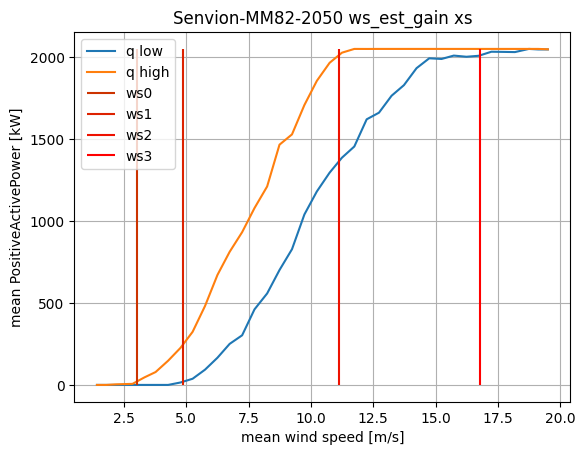

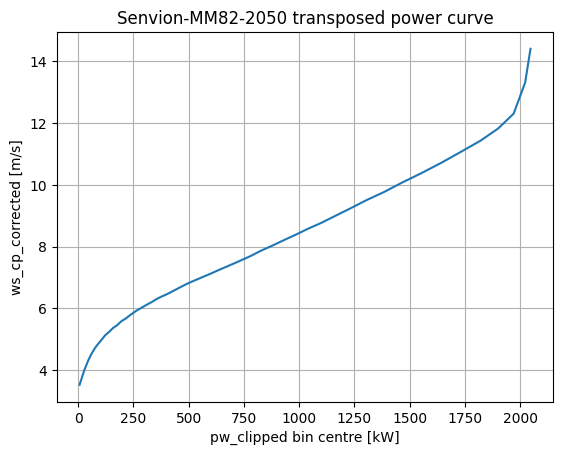

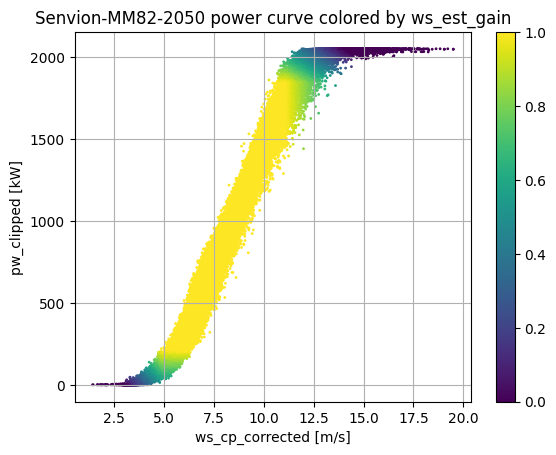

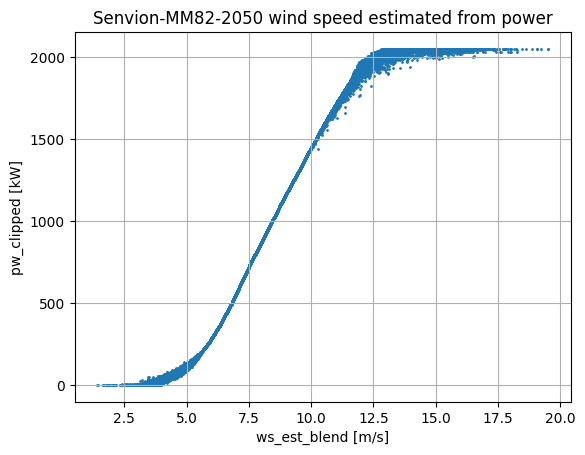

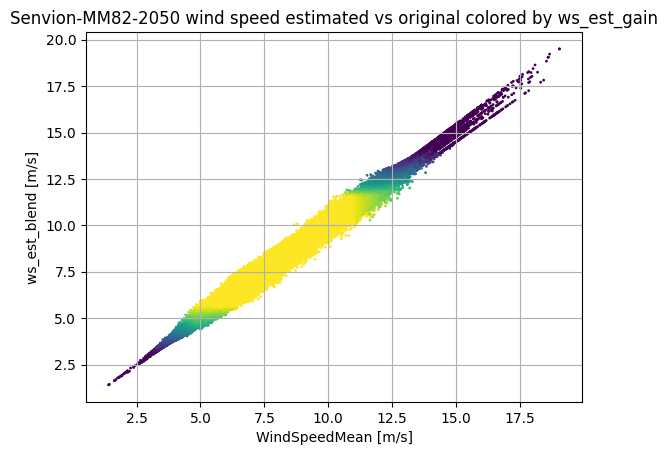

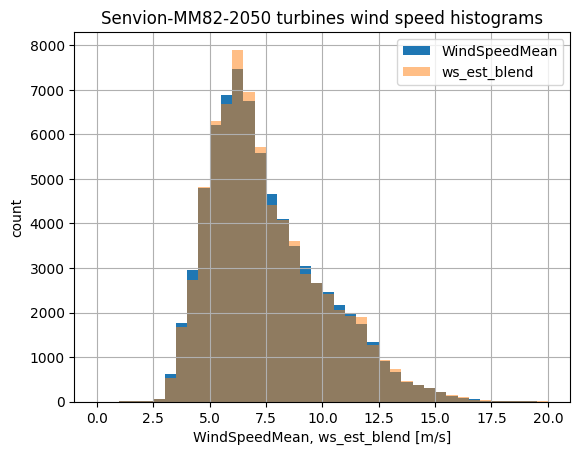

Senvion-MM82-2050 76.1% of rows are waking
Senvion-MM82-2050 14.8% of rows are not waking
Senvion-MM82-2050 9.1% of rows have unknown or partial waking


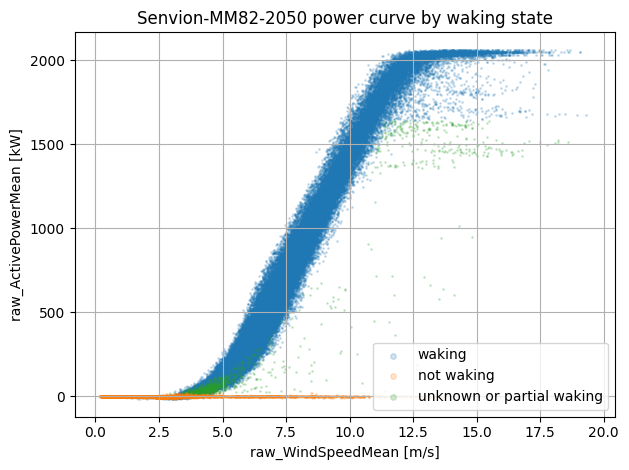

In [13]:
from wind_up.interface import AssessmentInputs

assessment_inputs = AssessmentInputs.from_cfg(
    cfg=cfg,
    plot_cfg=plot_cfg,
    toggle_df=toggle_df,
    scada_df=scada_df,
    metadata_df=metadata_df,
    reanalysis_datasets=[reanalysis_dataset],
    cache_dir=None,
)

## 5. Running the assessment

test turbines: ['SMV6', 'SMV5']
ref list: ['SMV7']
turbines to test: ['SMV6', 'SMV5']
filter_all_test_wtgs_together SMV5 set 400 rows [2.9%] to NA


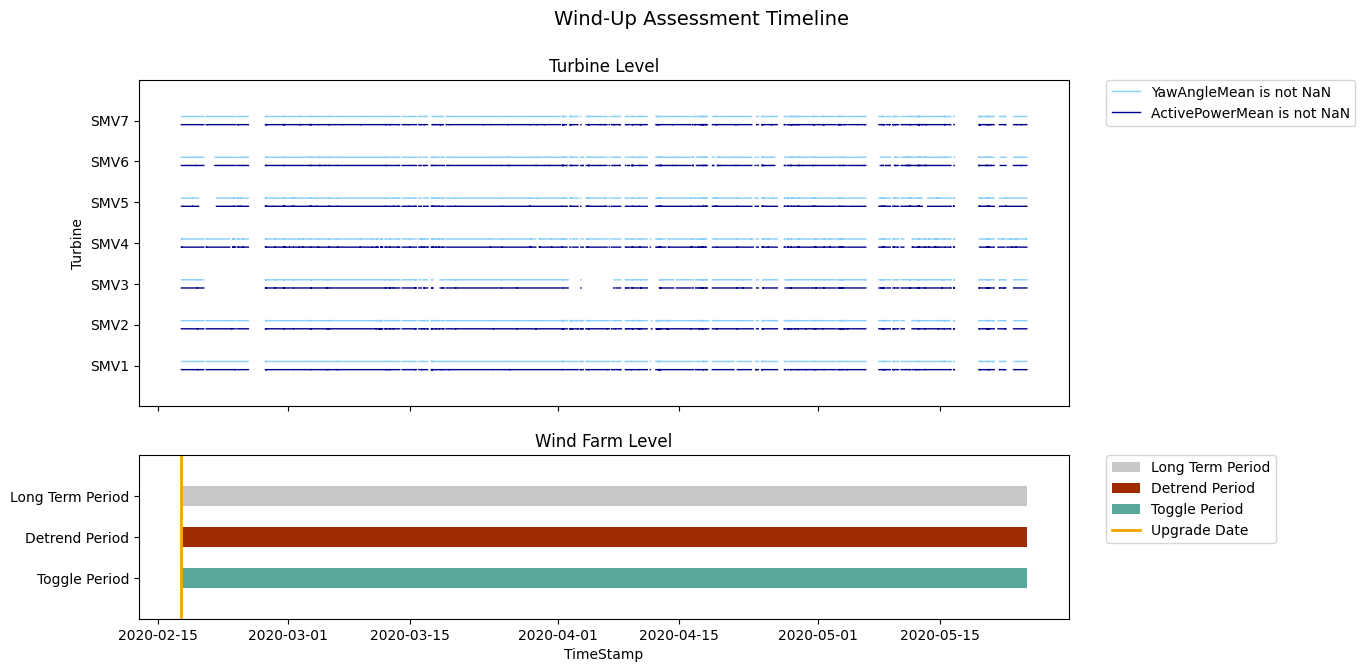

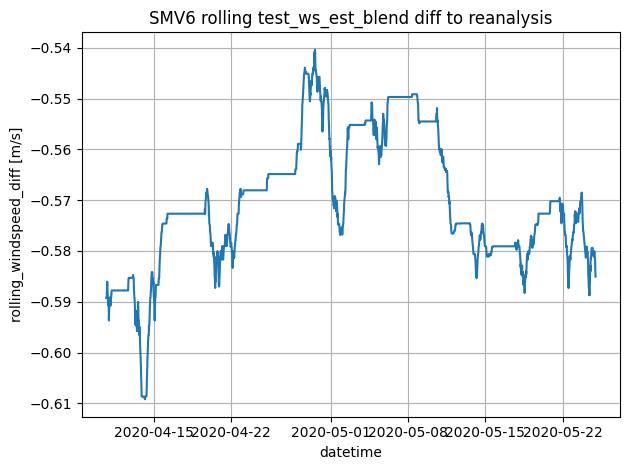

changed 764 [16.2%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120
changed 775 [9.9%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120
Column 'test_ReactivePowerMean' not found, skipping reactive vs active power plot for SMV6


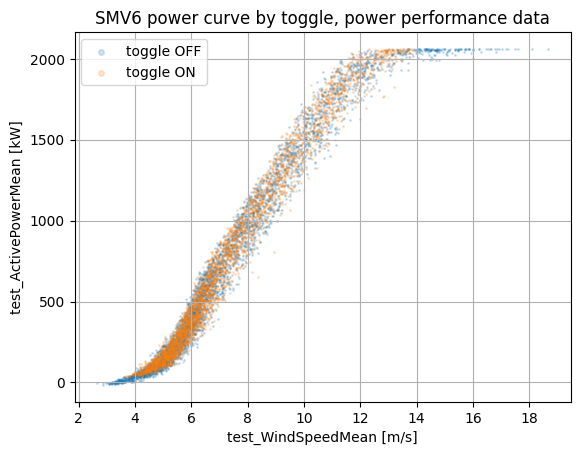

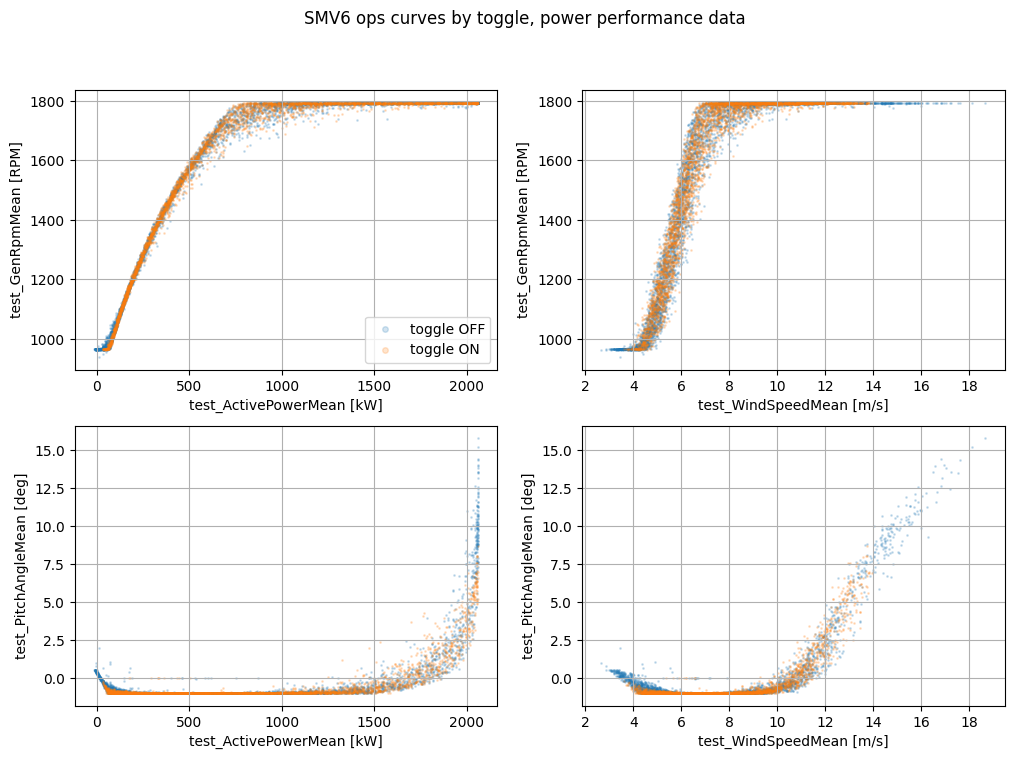

analysing SMV6 SMV7, loop_counter=0
changed 764 [16.2%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120
changed 775 [9.9%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120
removed 11629 [83.0%] rows from ref_df using ref_wd_filter
SMV7 wake free directions with data min=197.0 max=246.0
removed 0 [0.0%] rows from ref_df using require_ref_wake_free


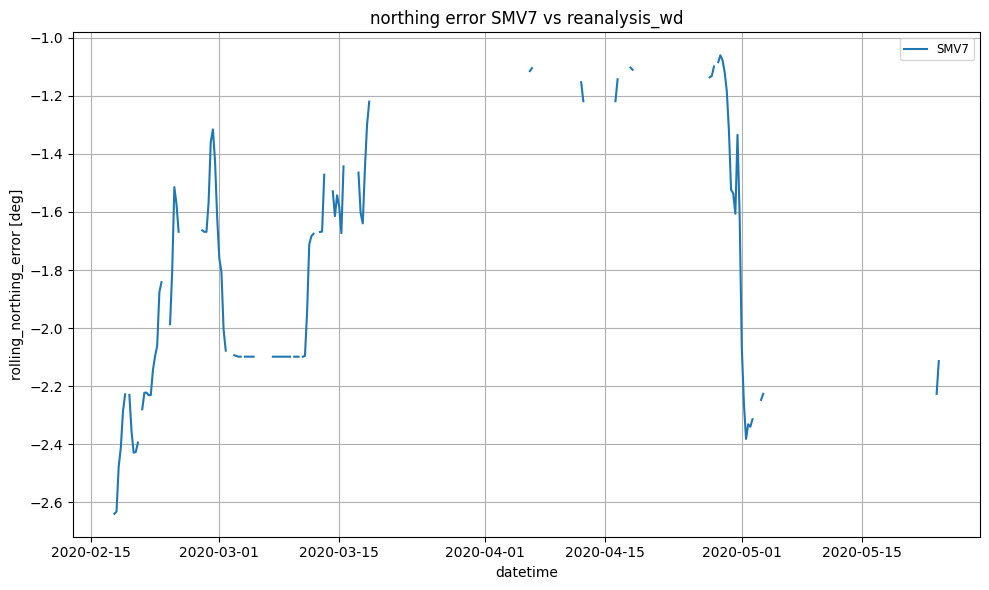

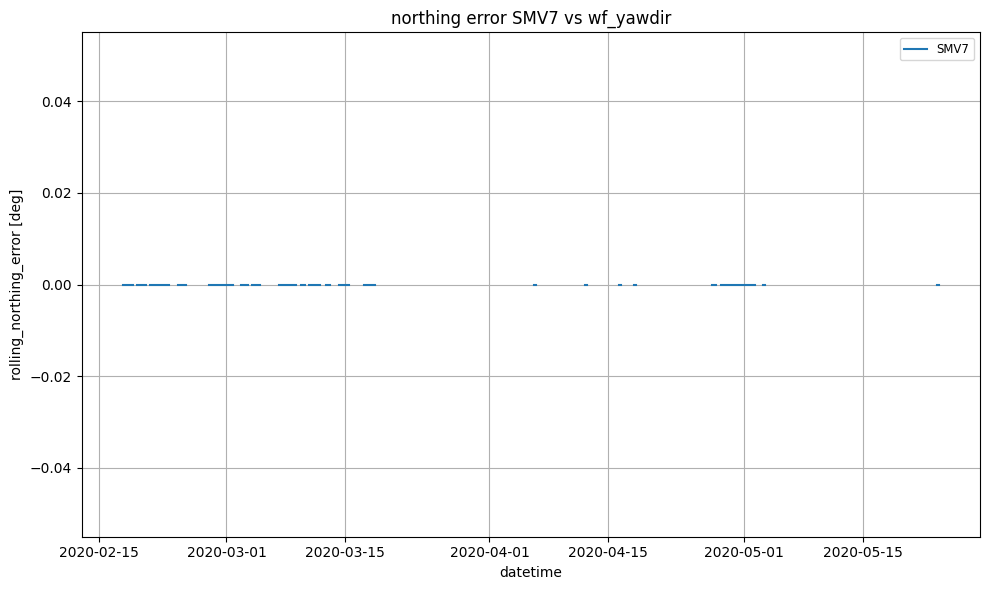

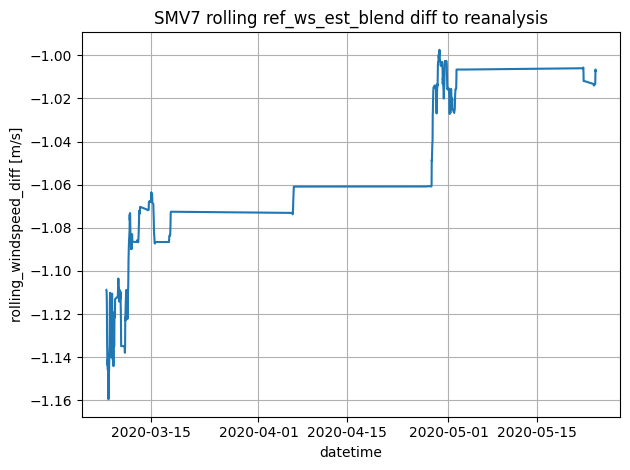

removed 6968 [49.7%] rows from detrend_df where test_toggle_off was not True after the first toggle on time
top 1 SMV6 SMV7 waking scenarios [%]:
+--------------+-------+
| none offline | 100.0 |
+--------------+-------+


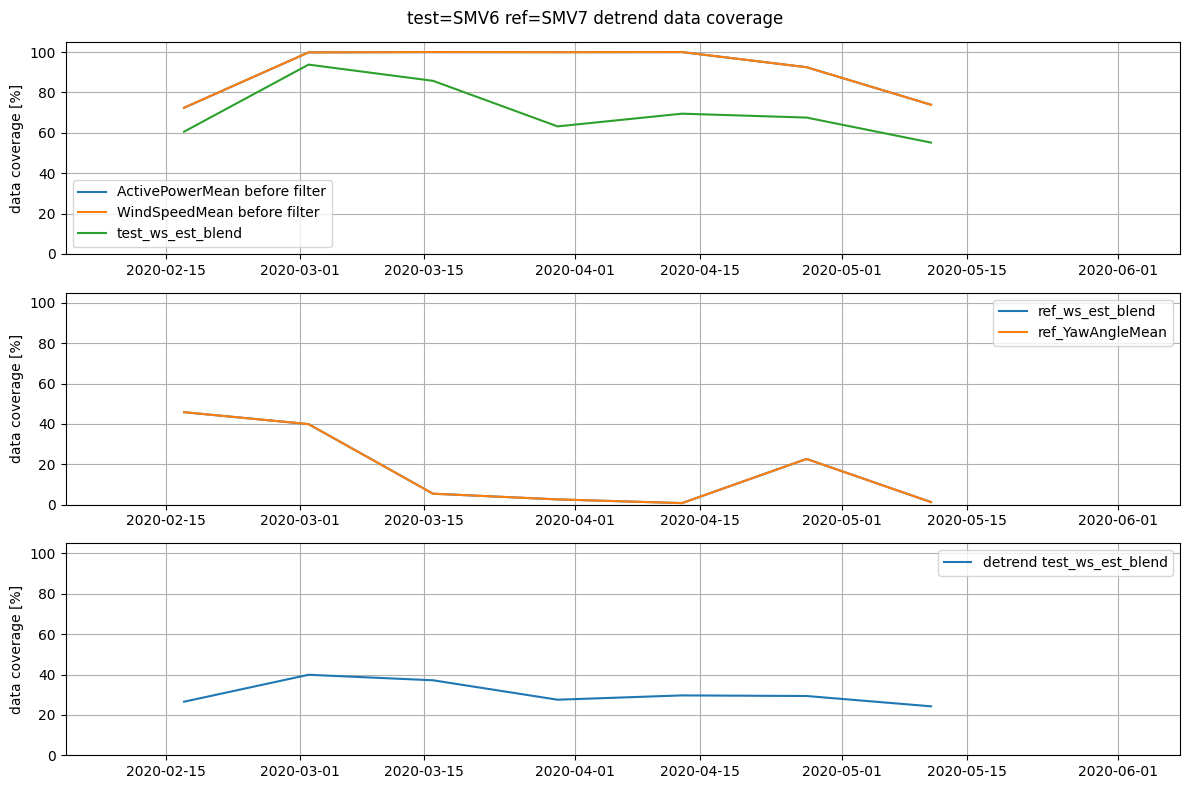

removed 0 bad detrend results


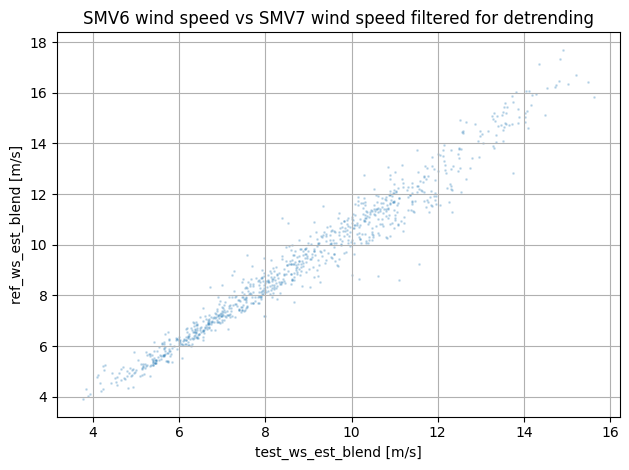

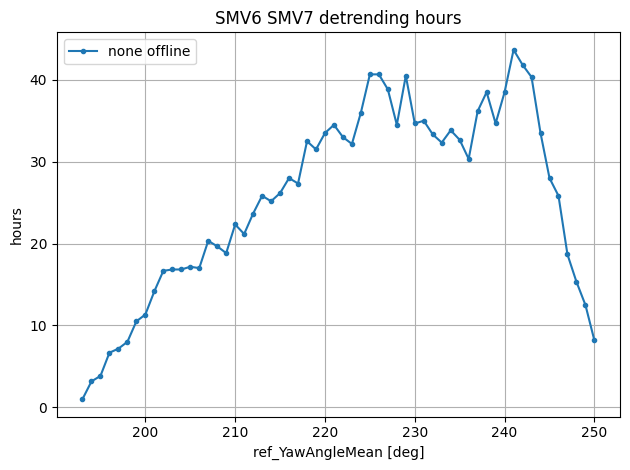

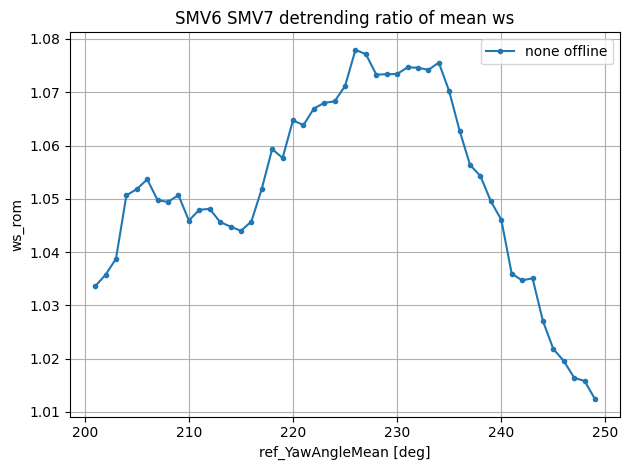

Column 'ref_ReactivePowerMean' not found, skipping reactive vs active power plot for SMV7


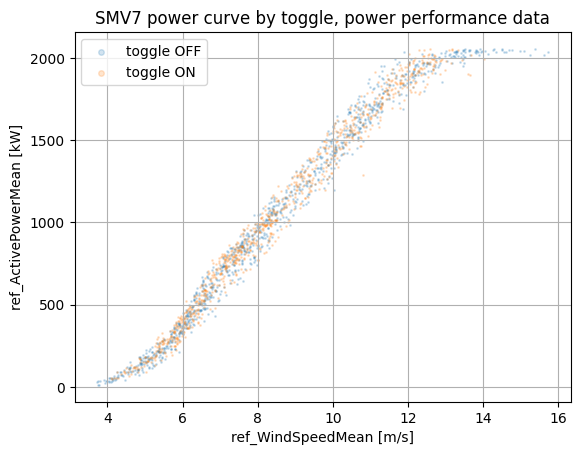

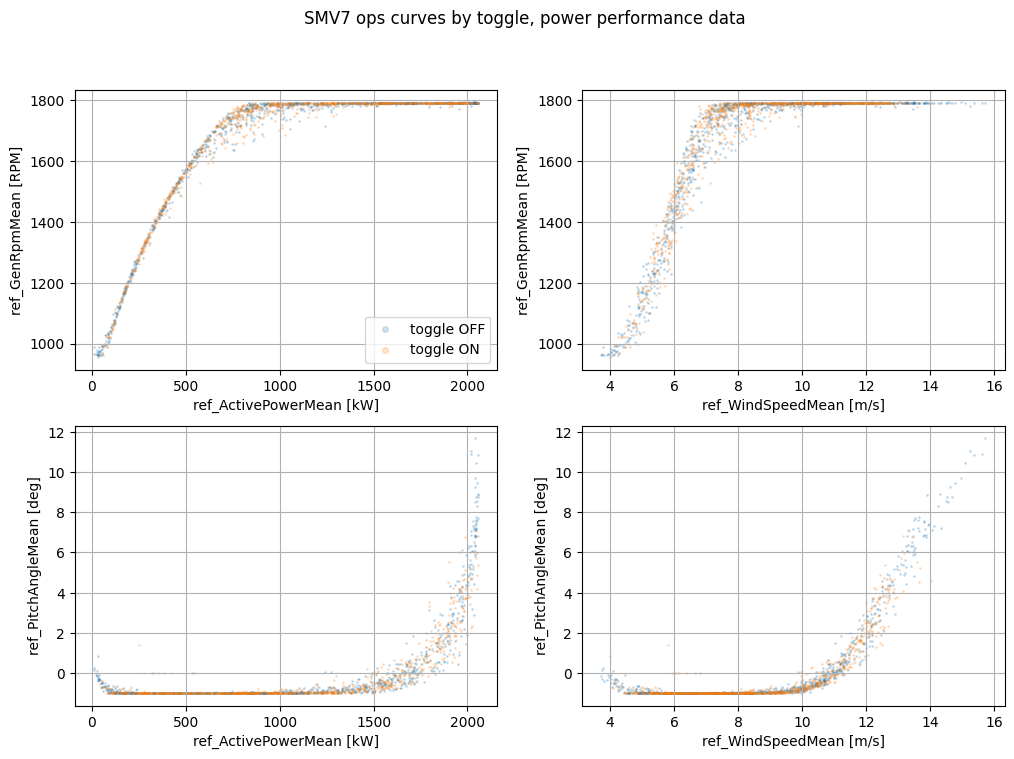

top 1 SMV6 SMV7 waking scenarios [%]:
+--------------+-------+
| none offline | 100.0 |
+--------------+-------+
top 1 SMV6 SMV7 waking scenarios [%]:
+--------------+-------+
| none offline | 100.0 |
+--------------+-------+
detrend applied to 49 scenario - directions


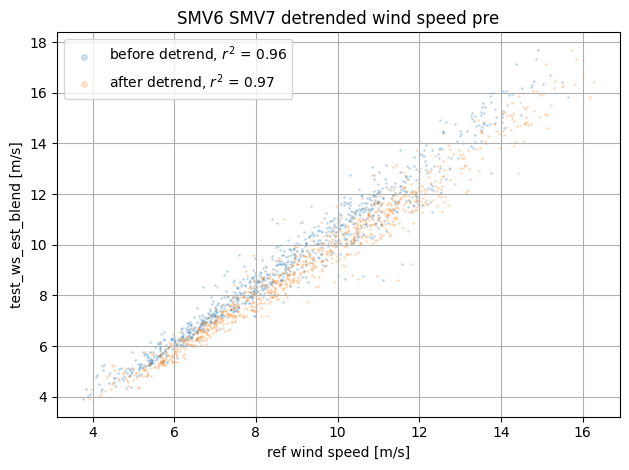

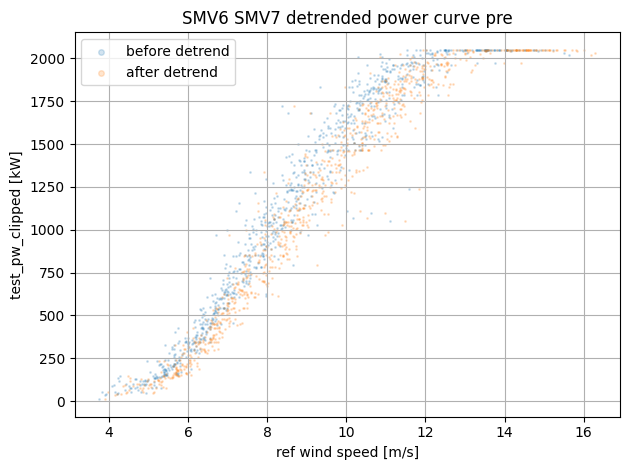

detrend applied to 49 scenario - directions


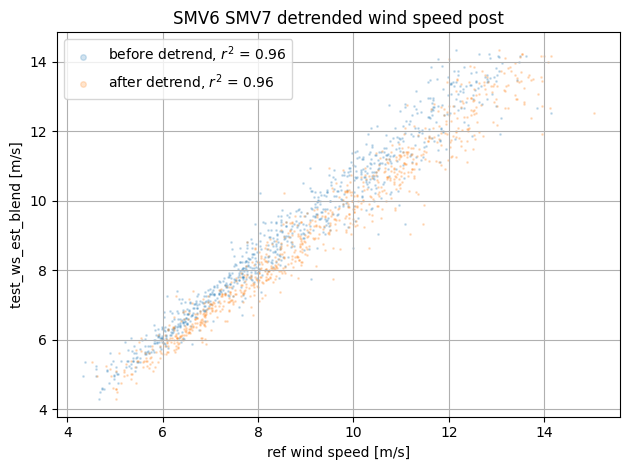

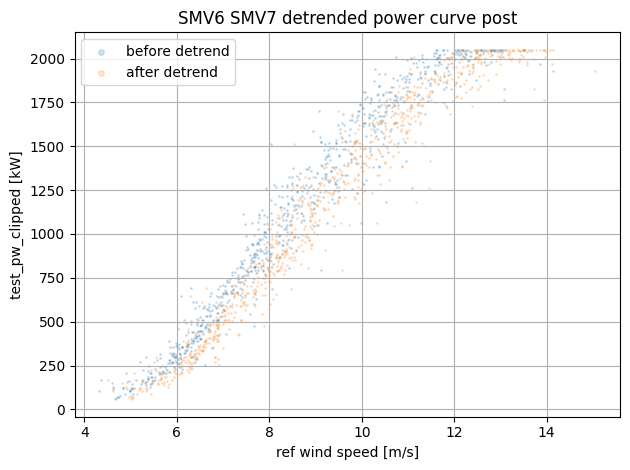

detrend improved pre_df ws r2 by 0.00 (0.96 to 0.97)
detrend improved post_df ws r2 by 0.00 (0.96 to 0.96)
removed 0 bad detrend results
removed 0 bad detrend results


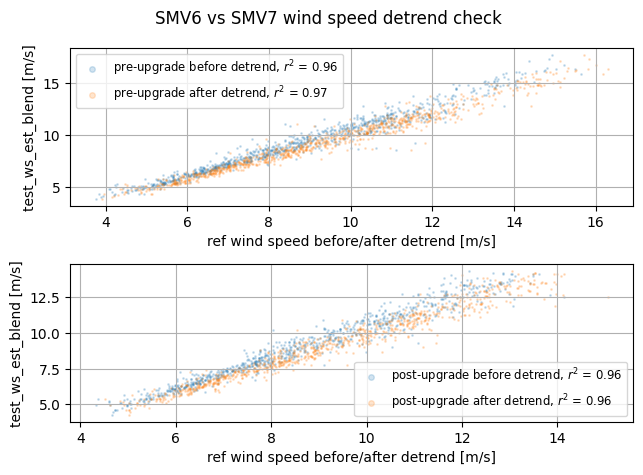

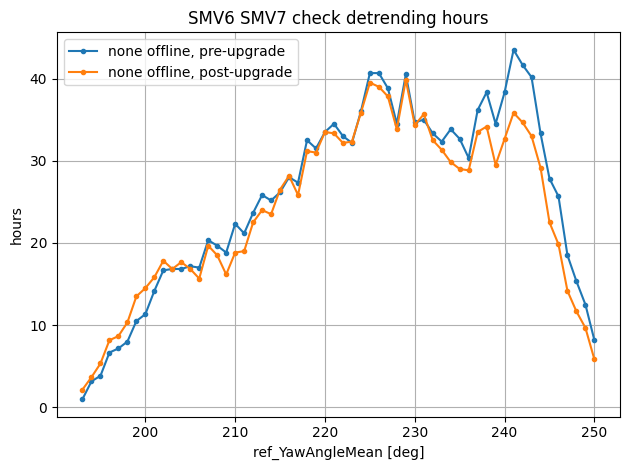

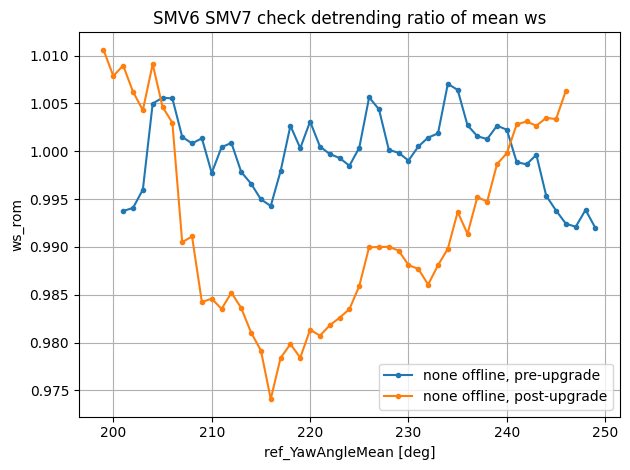

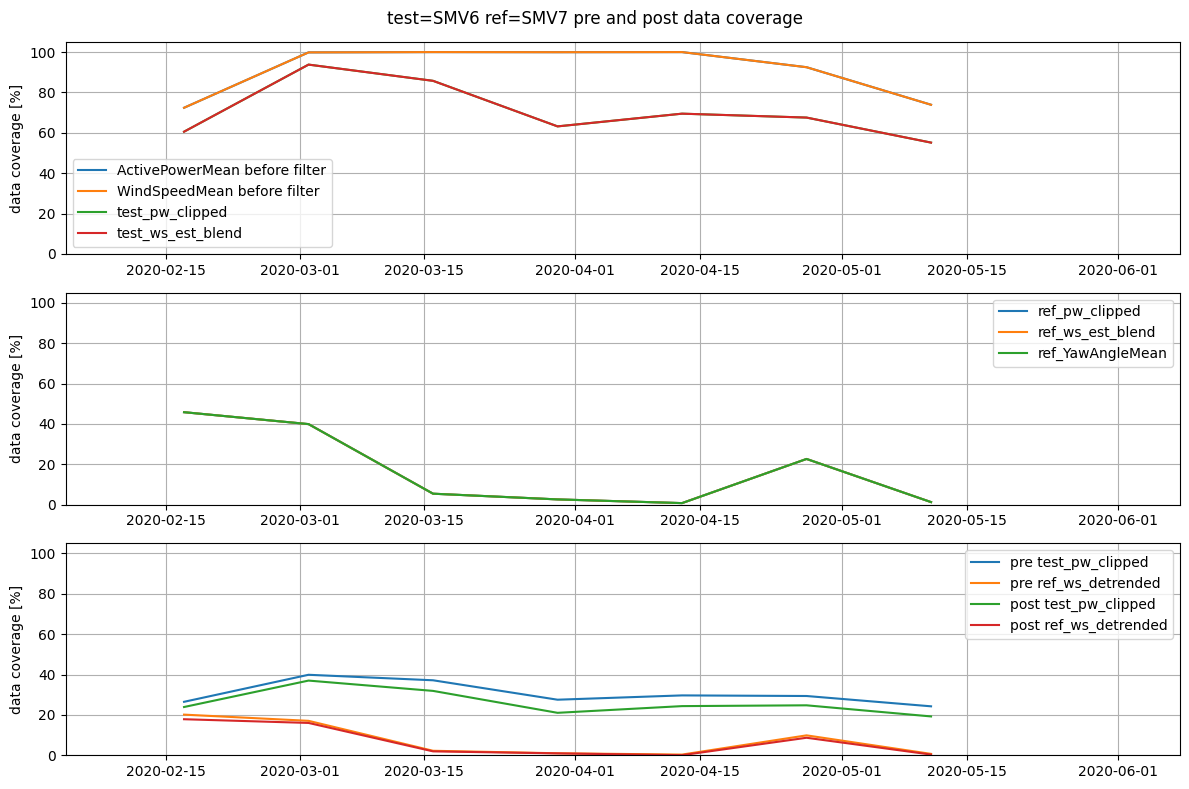

removed 71 [7.8%] rows from pre_df using any_within_timedelta pairing filter
removed 12 [1.4%] rows from post_df using any_within_timedelta pairing filter


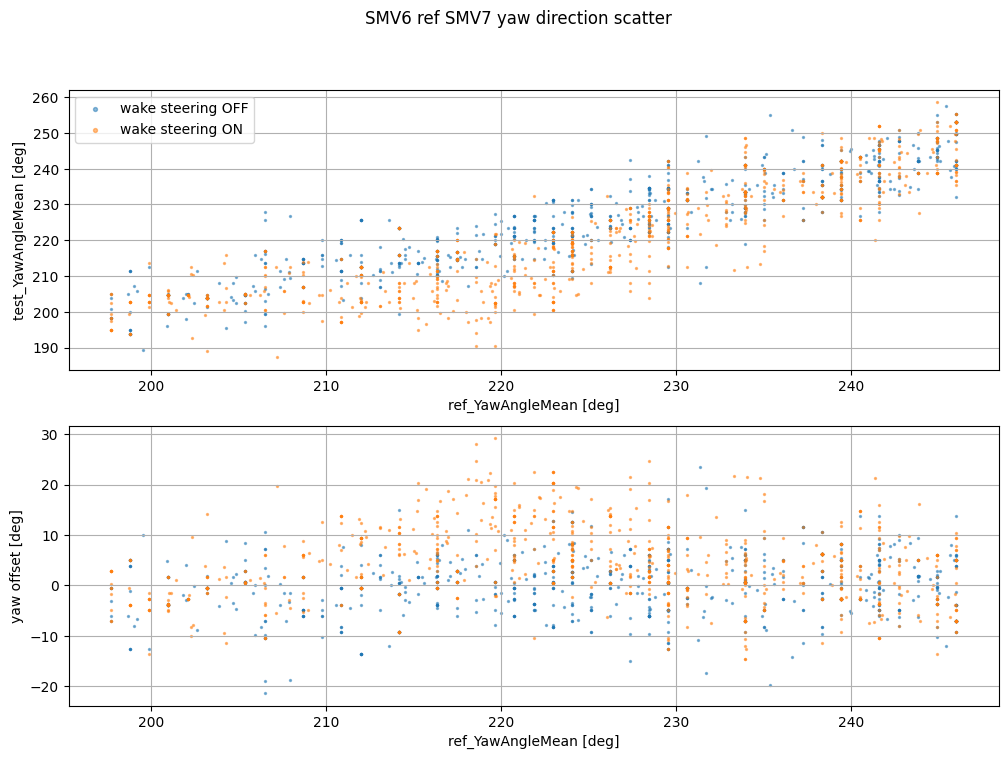

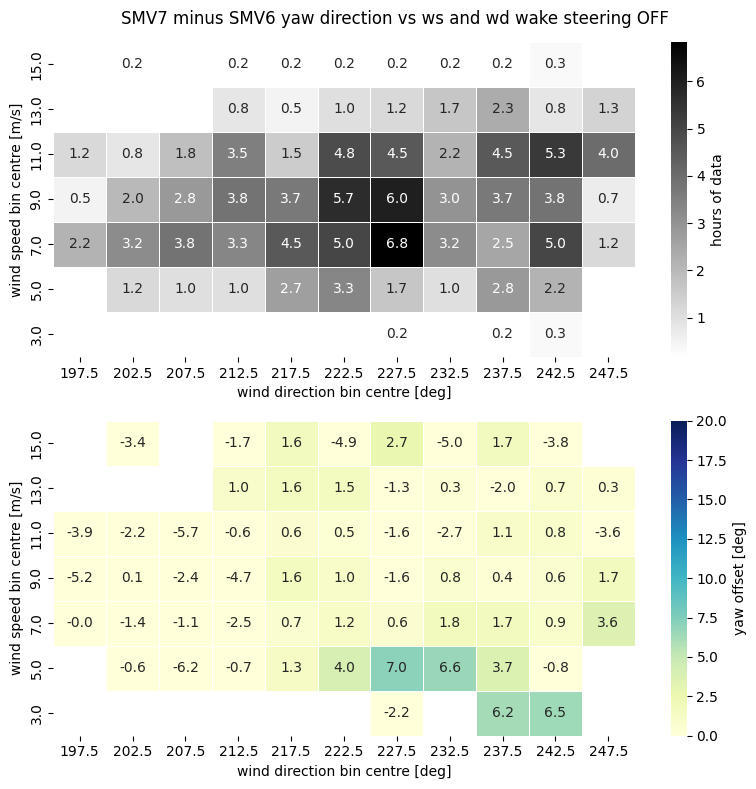

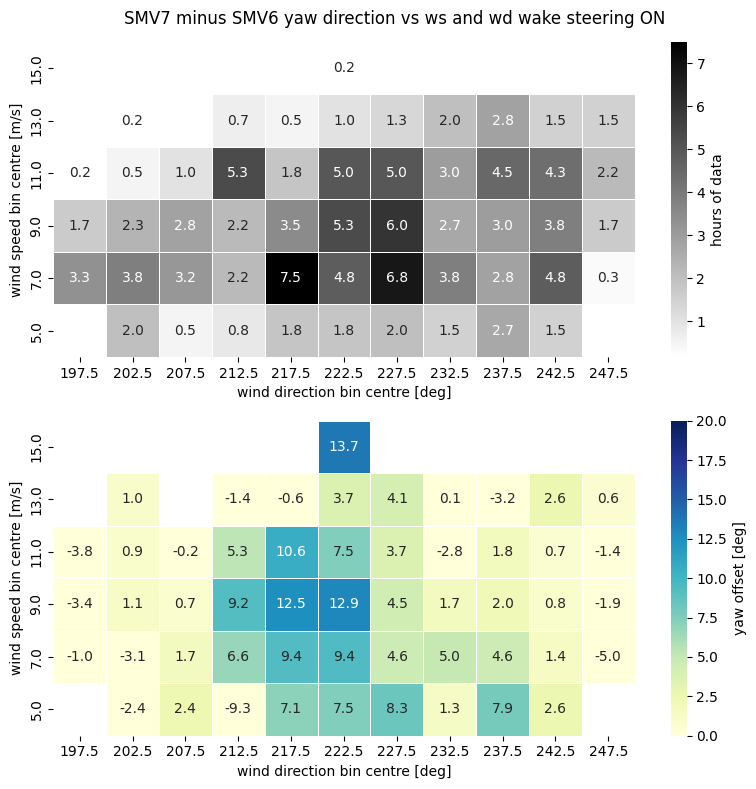

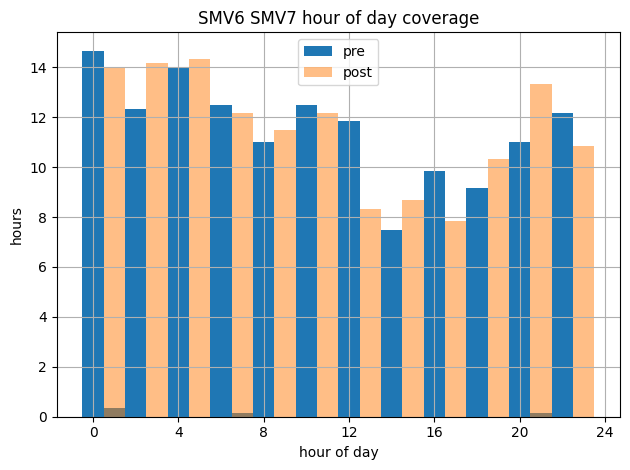

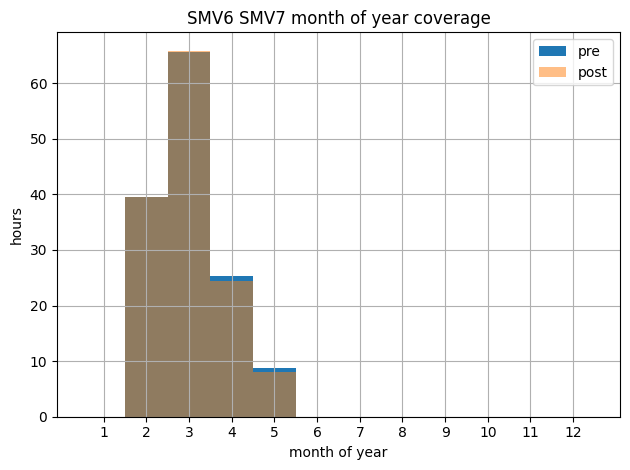

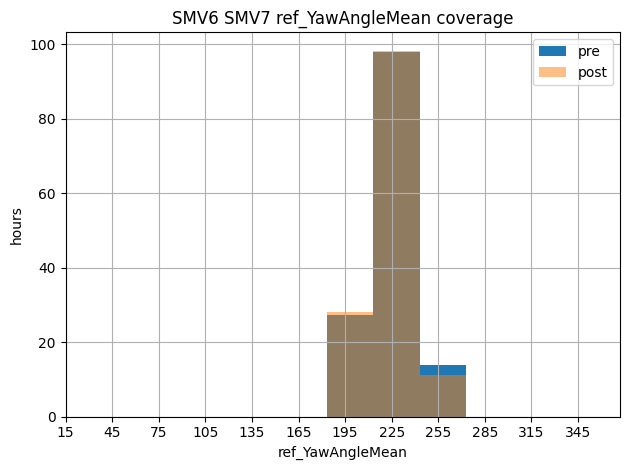

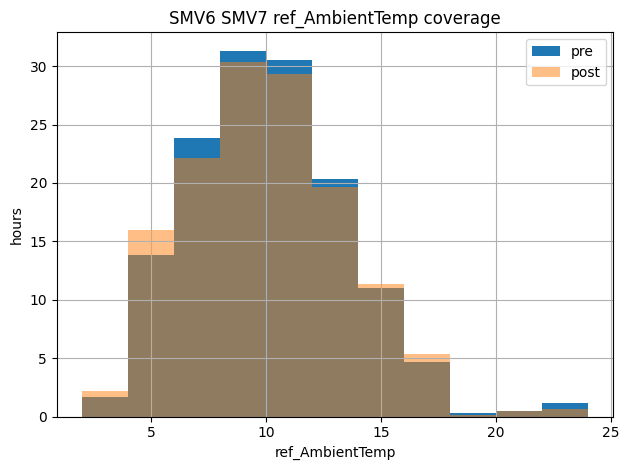

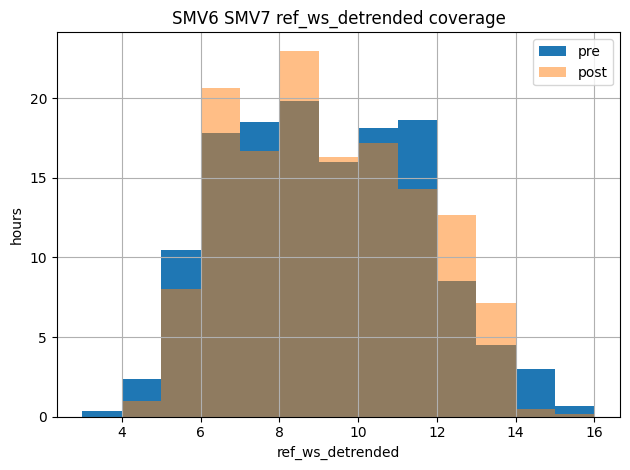

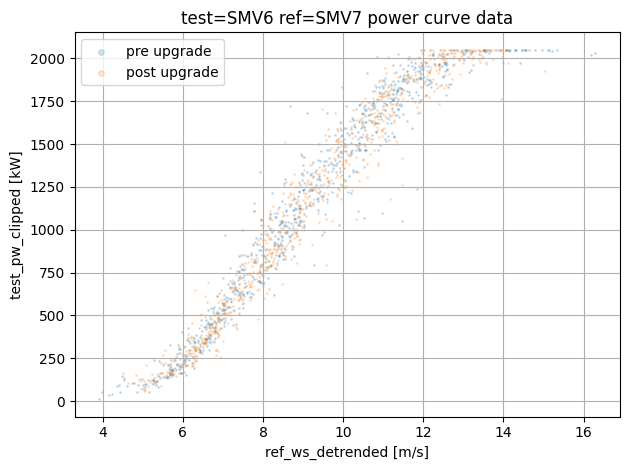

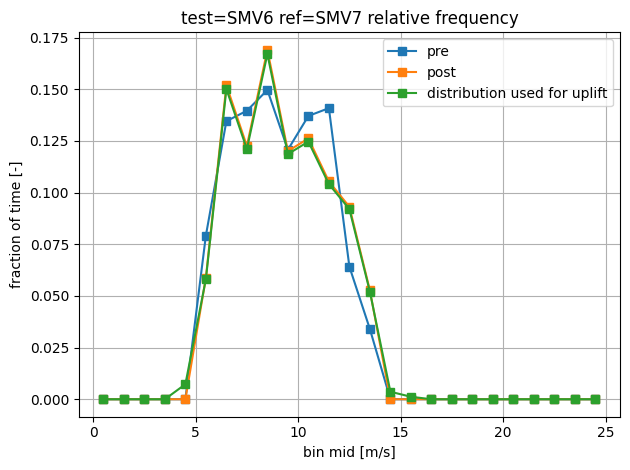

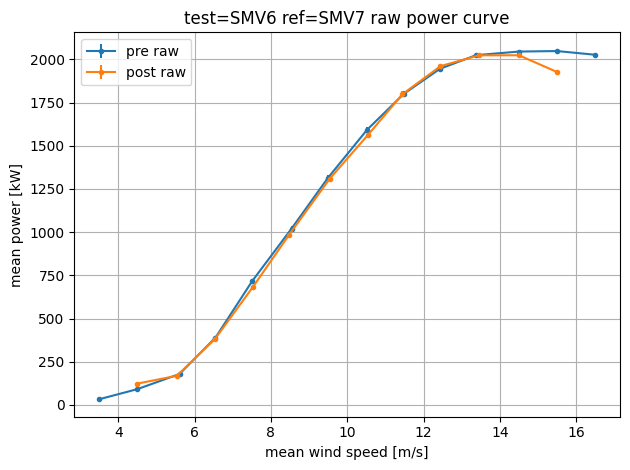

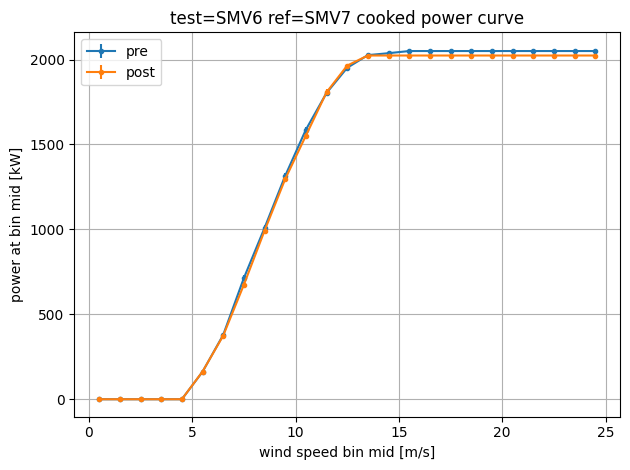

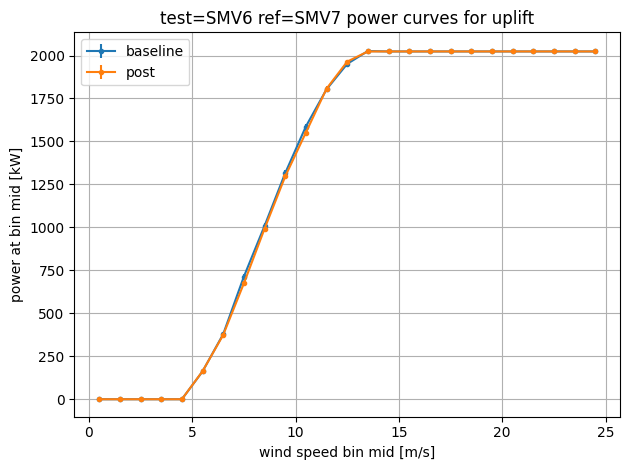

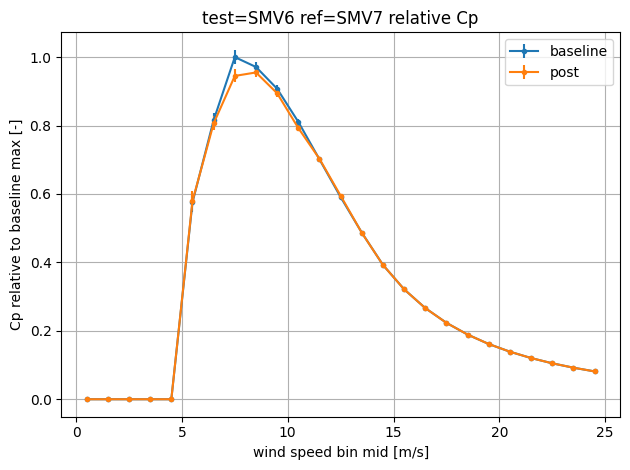

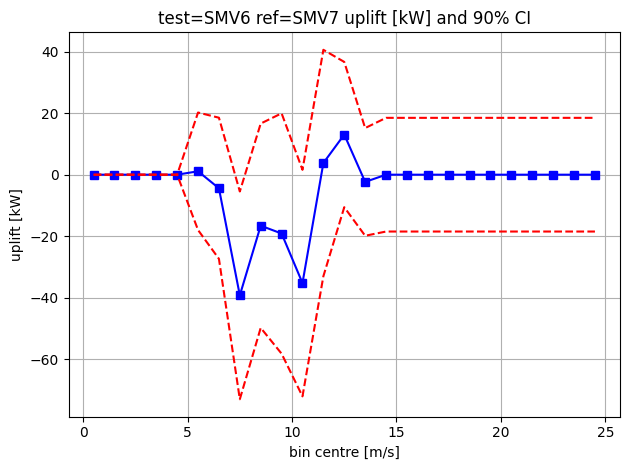

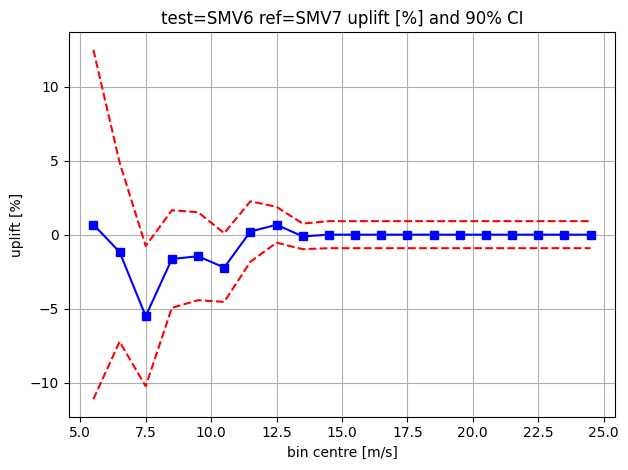

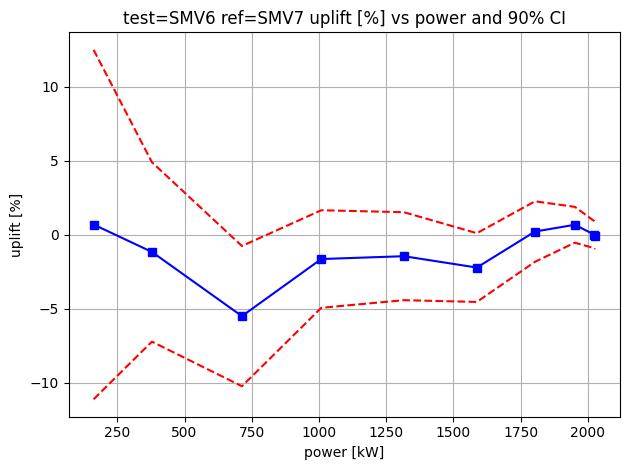

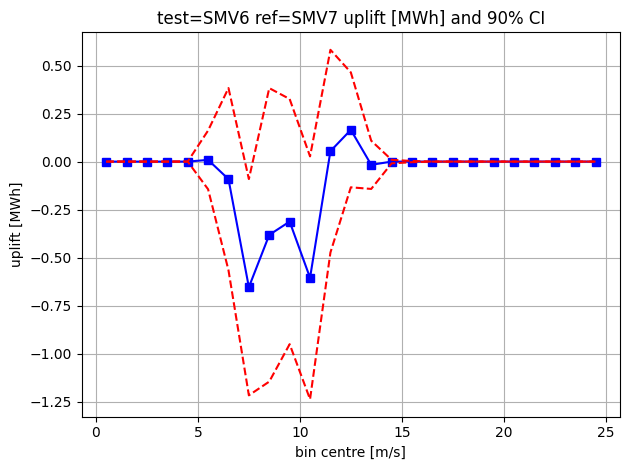

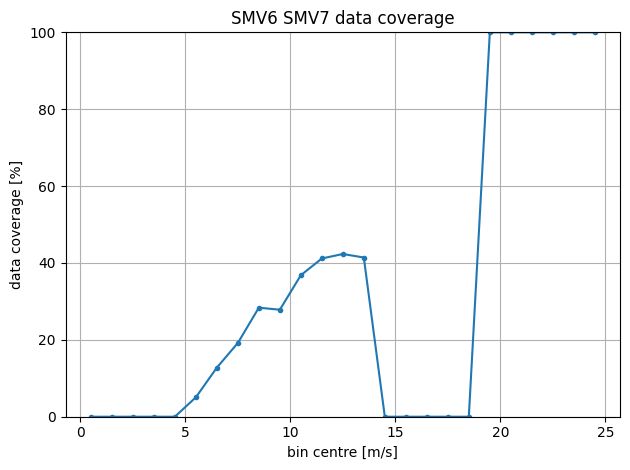


results for test=SMV6 ref=SMV7:

hours pre = 132.5
hours post = 136.0

uplift estimate before adjustments = -1.2 %

power only uplift estimate = -1.2 %
reversed (power only) uplift estimate = -1.0 %

Running block bootstrapping uncertainty analysis n_samples = 400


  0%|          | 0/400 [00:00<?, ?it/s]

block bootstrapping uncertainty analysis results (conf=90%):
  median = -1.1 %
  lower = -2.0 %
  upper = -0.4 %
  unc_one_sigma = 0.5 %

cat A 1 sigma unc = 0.6 %
abs reversal error / 2 = 0.1 %
bootstrap 1 sigma unc = 0.5 %
missing bins scale factor = 1.000
final 1 sigma unc = 0.6 %

final uplift estimate = -1.0 %
final P95 uplift estimate = -2.0 %
final P5 uplift estimate = -0.1 %
{'ref': 'SMV7', 'ref_ws_col': 'ref_ws_est_blend', 'distance_m': 314.4465998943834, 'bearing_deg': 173.69483366777283, 'ref_max_northing_error_v_reanalysis': np.float64(2.673922401887239), 'ref_max_northing_error_v_wf': np.float64(0.0), 'ref_max_ws_drift': np.float64(0.08697706942338845), 'ref_max_ws_drift_pp_period': np.float64(0.08697706942338845), 'ref_powercurve_shift': np.float64(0.003117456887993697), 'ref_rpm_shift': np.float64(0.0015313319638985412), 'ref_pitch_shift': np.float64(-0.05548555519736481), 'detrend_pre_r2_improvement': np.float64(0.004942384513915488), 'detrend_post_r2_improvement': np.f

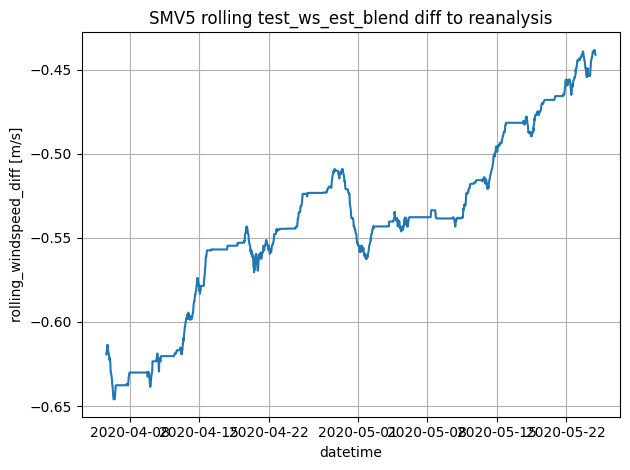

changed 764 [16.2%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120
changed 775 [9.9%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120
Column 'test_ReactivePowerMean' not found, skipping reactive vs active power plot for SMV5


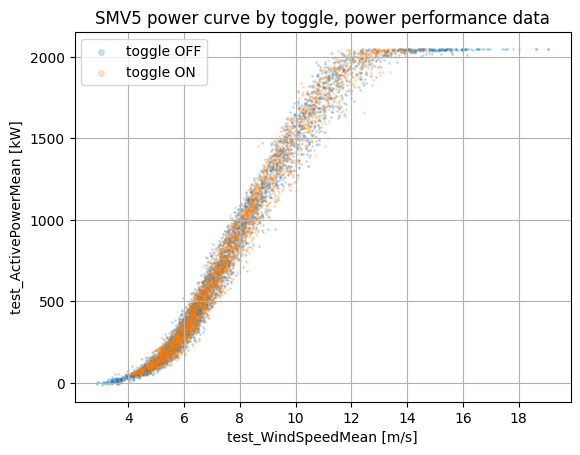

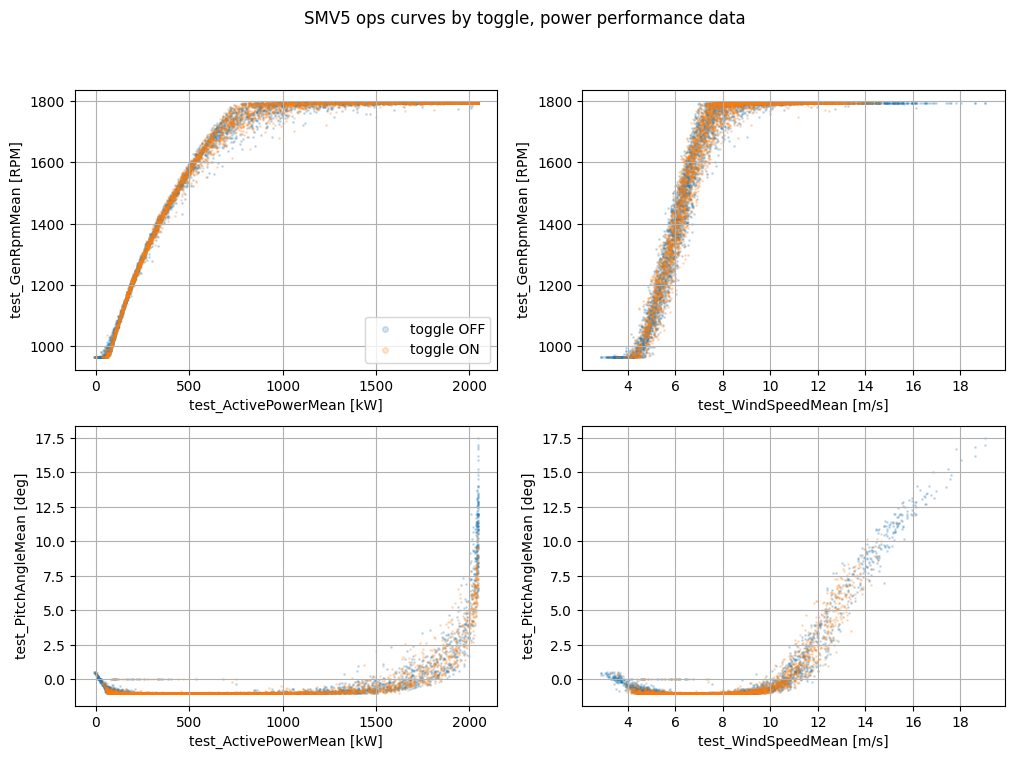

analysing SMV5 SMV7, loop_counter=1
changed 764 [16.2%] rows from toggle_on True to False because toggle_change_settling_filter_seconds = 120
changed 775 [9.9%] rows from toggle_off True to False because toggle_change_settling_filter_seconds = 120
removed 11629 [83.0%] rows from ref_df using ref_wd_filter
SMV7 wake free directions with data min=197.0 max=246.0
removed 0 [0.0%] rows from ref_df using require_ref_wake_free


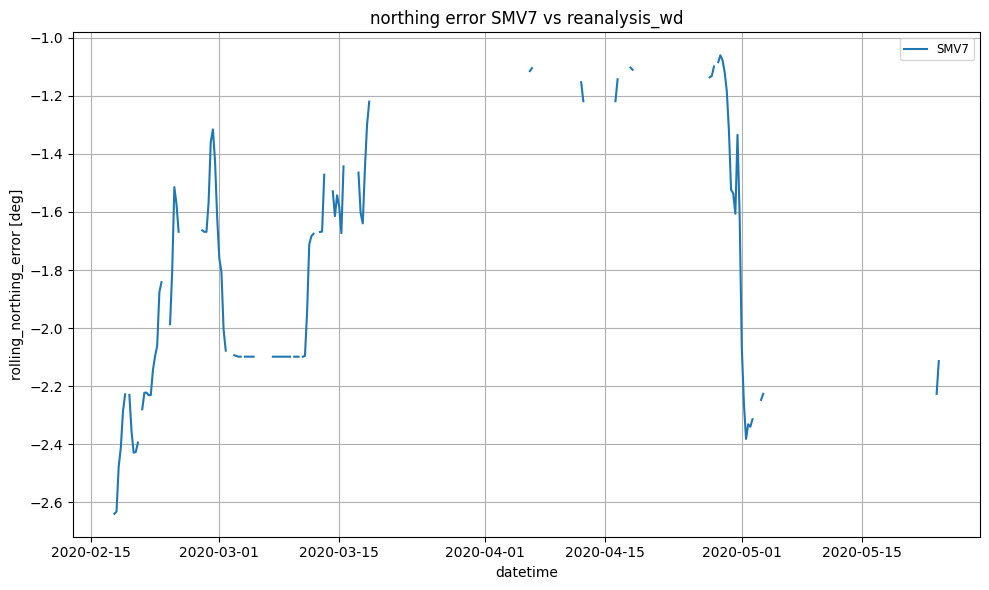

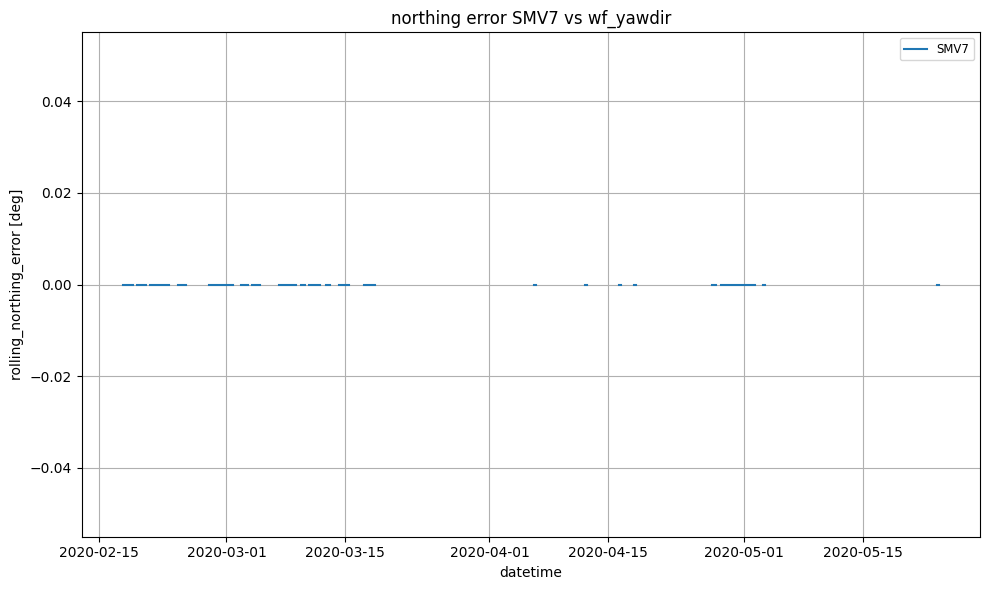

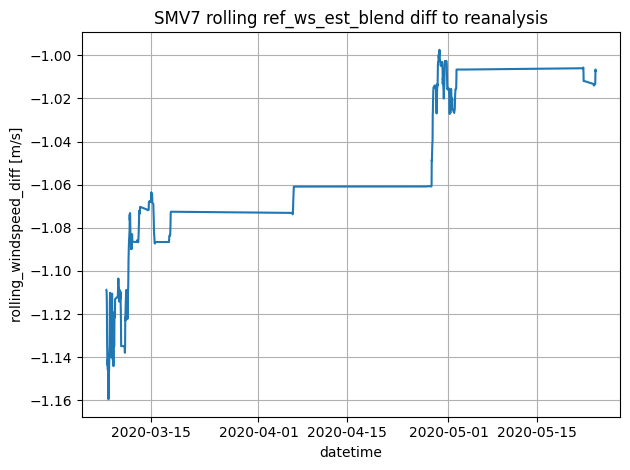

removed 6968 [49.7%] rows from detrend_df where test_toggle_off was not True after the first toggle on time
top 3 SMV5 SMV7 waking scenarios [%]:
+--------------+------+
| none offline | 95.4 |
| unknown      |  4.1 |
| SMV6 offline |  0.6 |
+--------------+------+


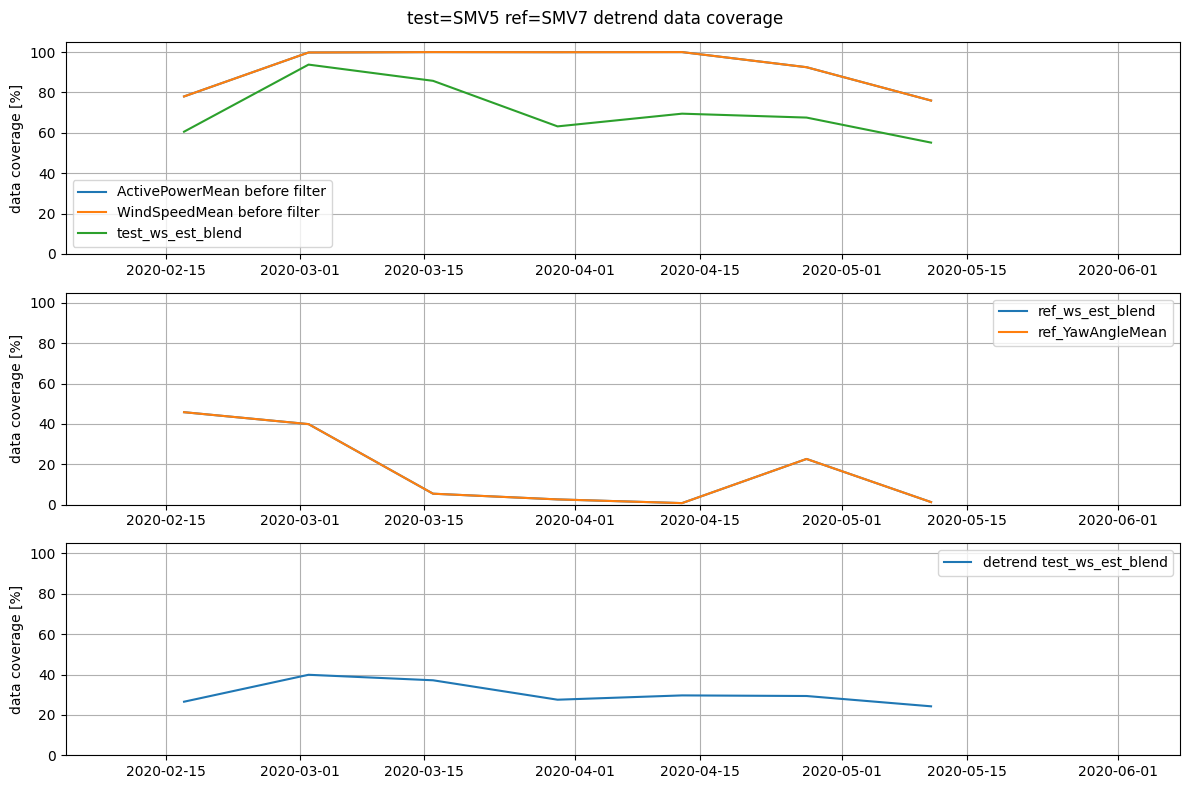

removed 0 bad detrend results


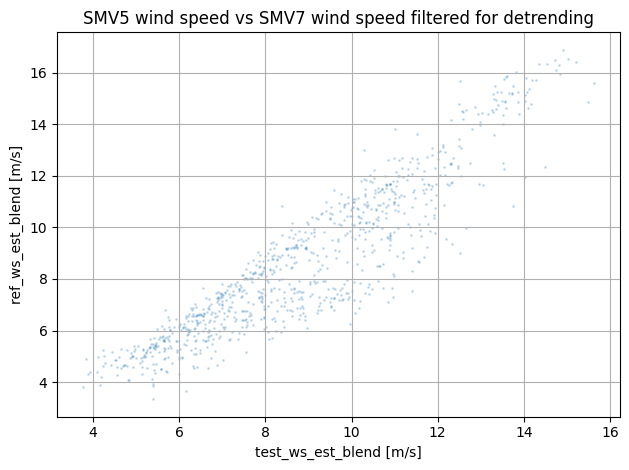

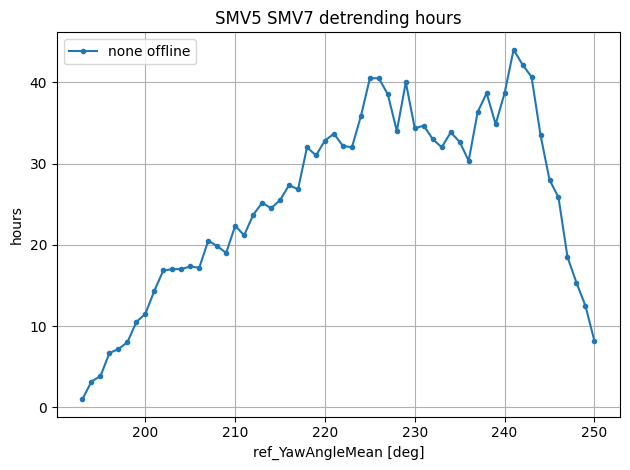

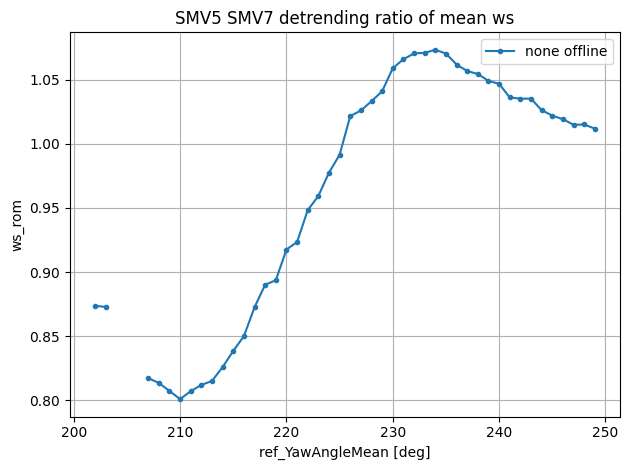

Column 'ref_ReactivePowerMean' not found, skipping reactive vs active power plot for SMV7


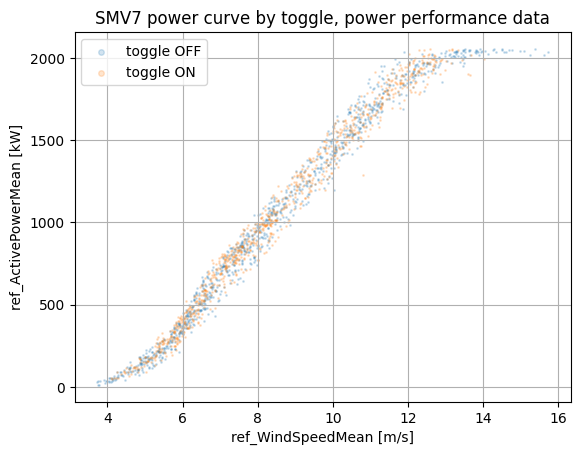

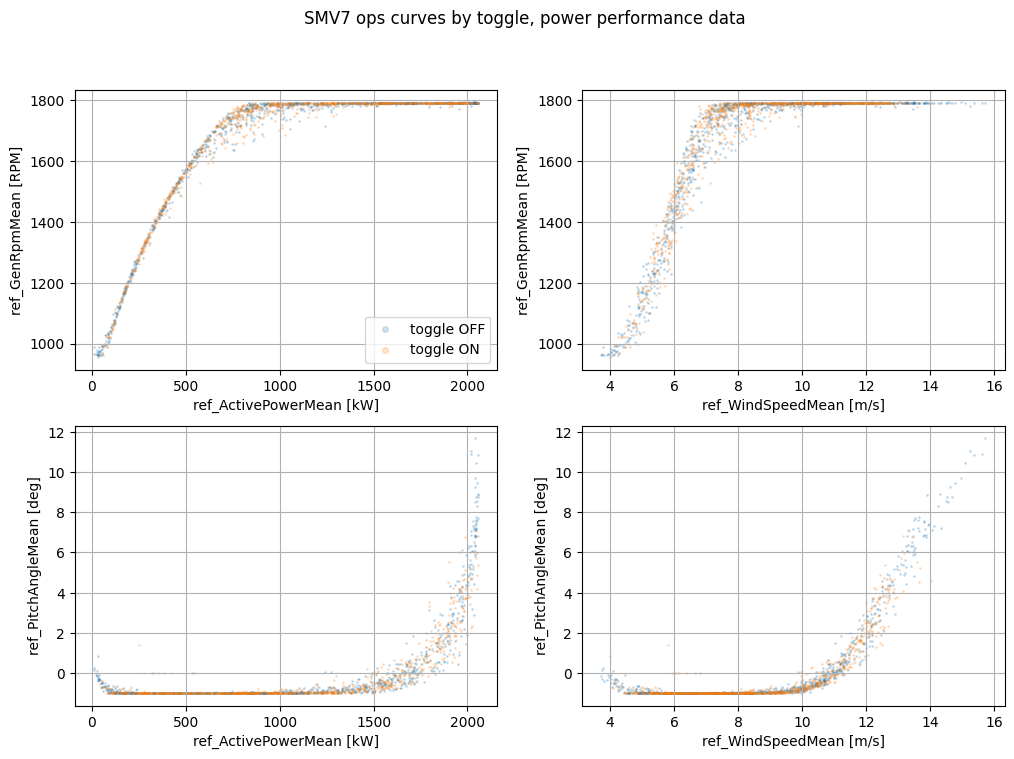

top 3 SMV5 SMV7 waking scenarios [%]:
+--------------+------+
| none offline | 95.4 |
| unknown      |  4.1 |
| SMV6 offline |  0.6 |
+--------------+------+
top 2 SMV5 SMV7 waking scenarios [%]:
+--------------+------+
| none offline | 97.6 |
| unknown      |  2.4 |
+--------------+------+
detrend applied to 65 scenario - directions


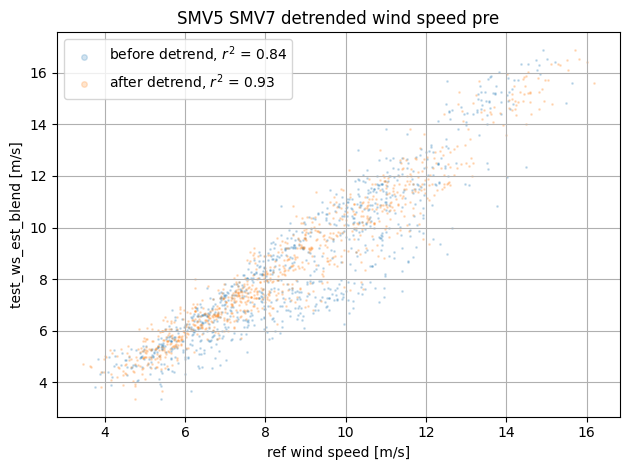

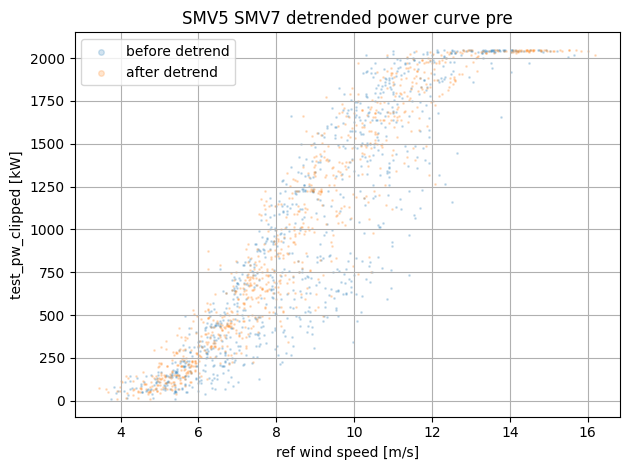

detrend applied to 58 scenario - directions


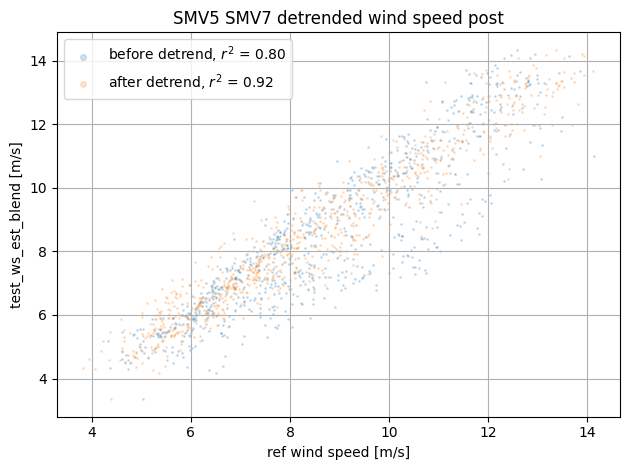

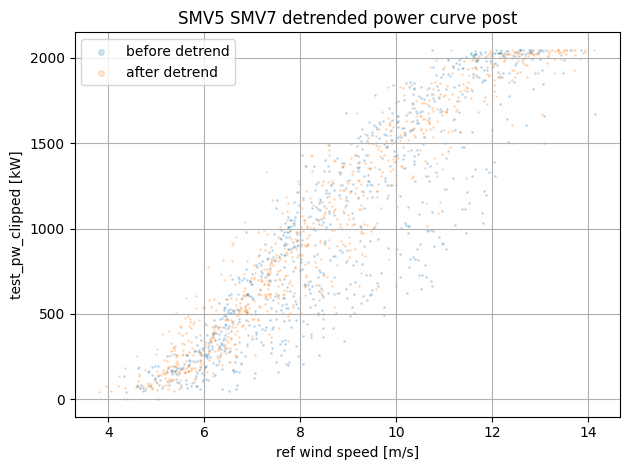

detrend improved pre_df ws r2 by 0.10 (0.84 to 0.93)
detrend improved post_df ws r2 by 0.12 (0.80 to 0.92)
removed 0 bad detrend results
removed 0 bad detrend results


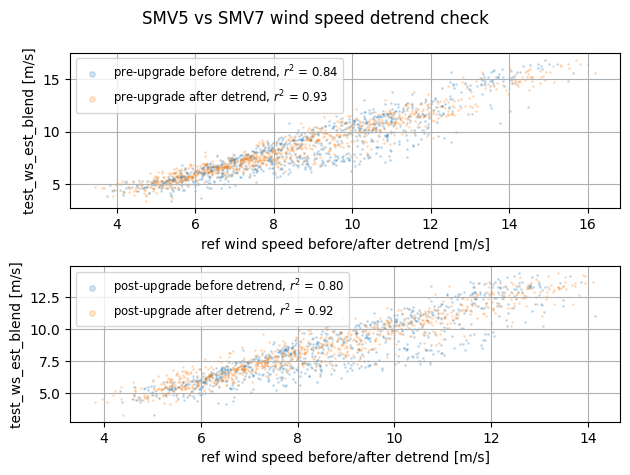

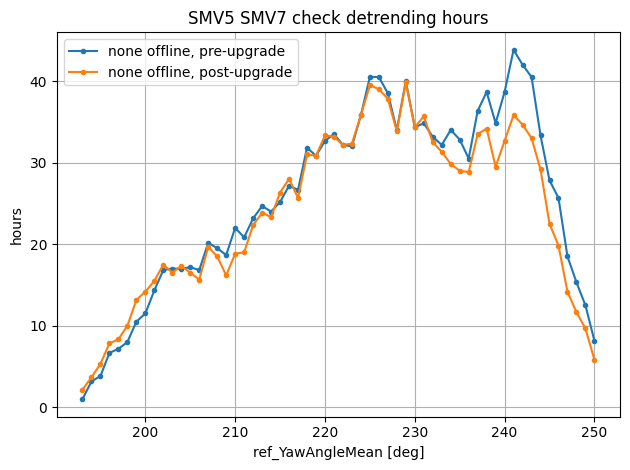

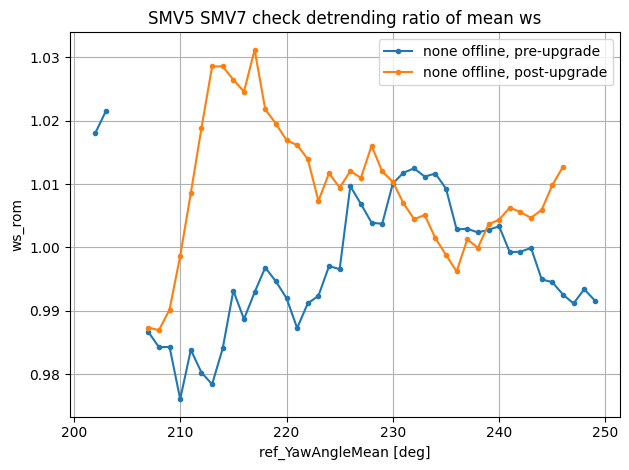

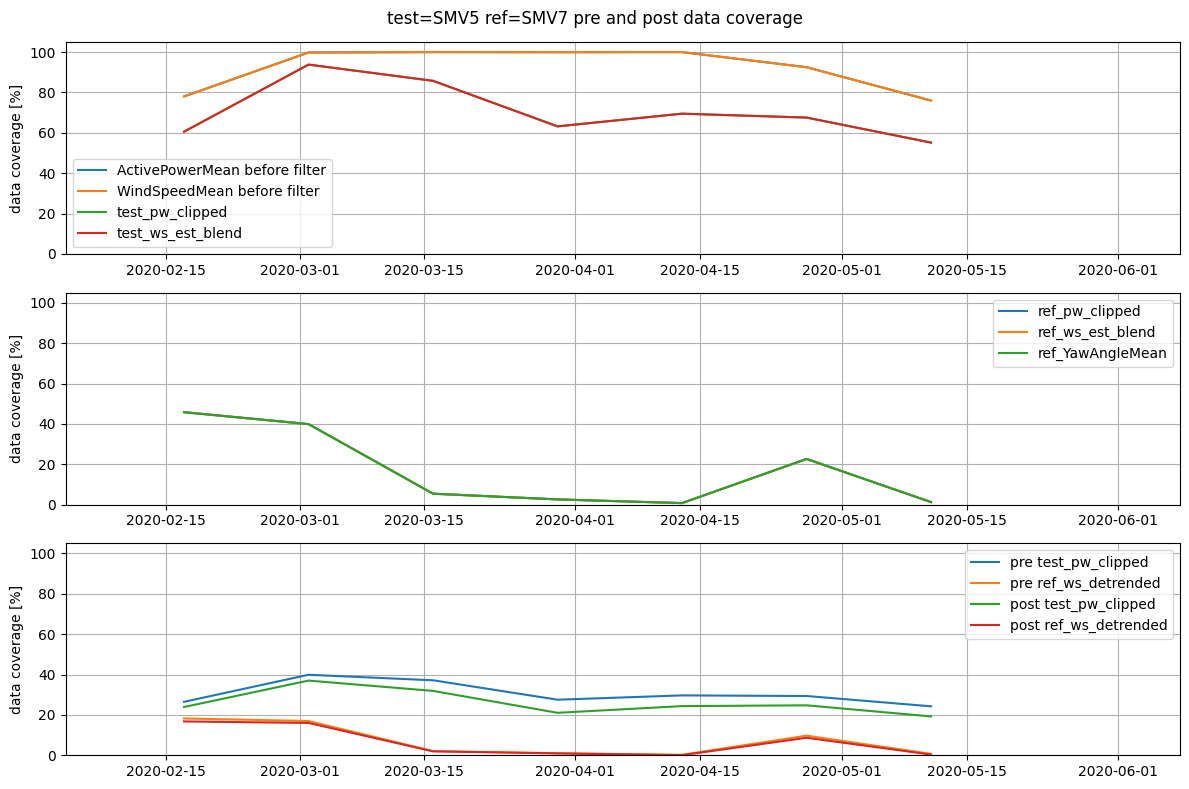

removed 71 [7.8%] rows from pre_df using any_within_timedelta pairing filter
removed 12 [1.4%] rows from post_df using any_within_timedelta pairing filter


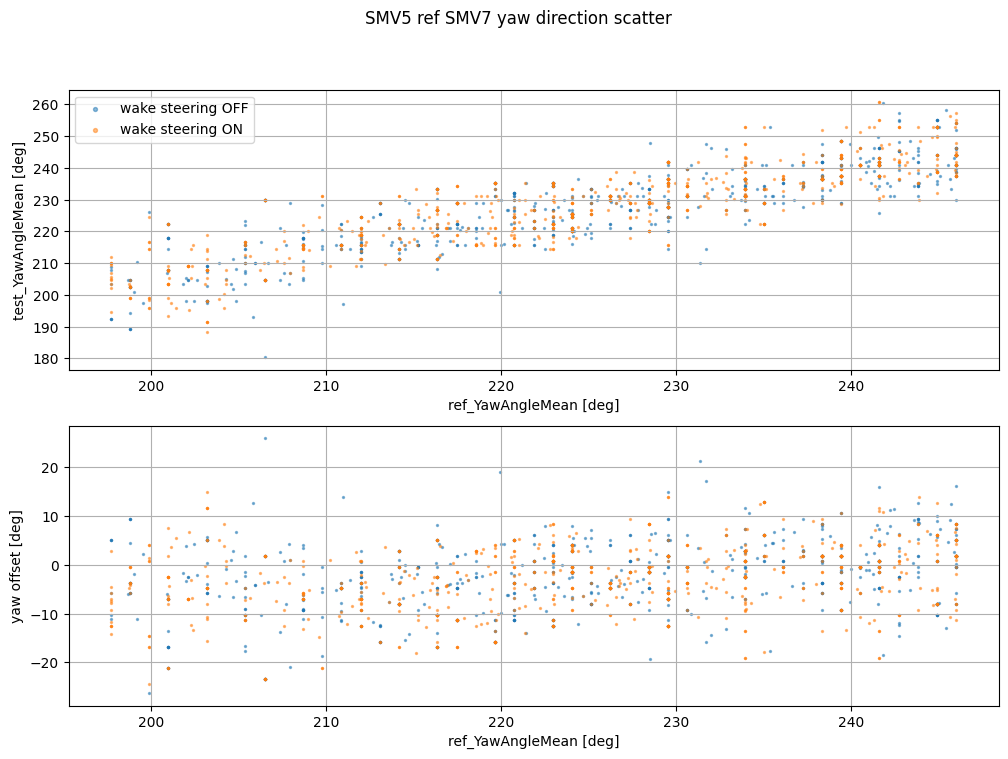

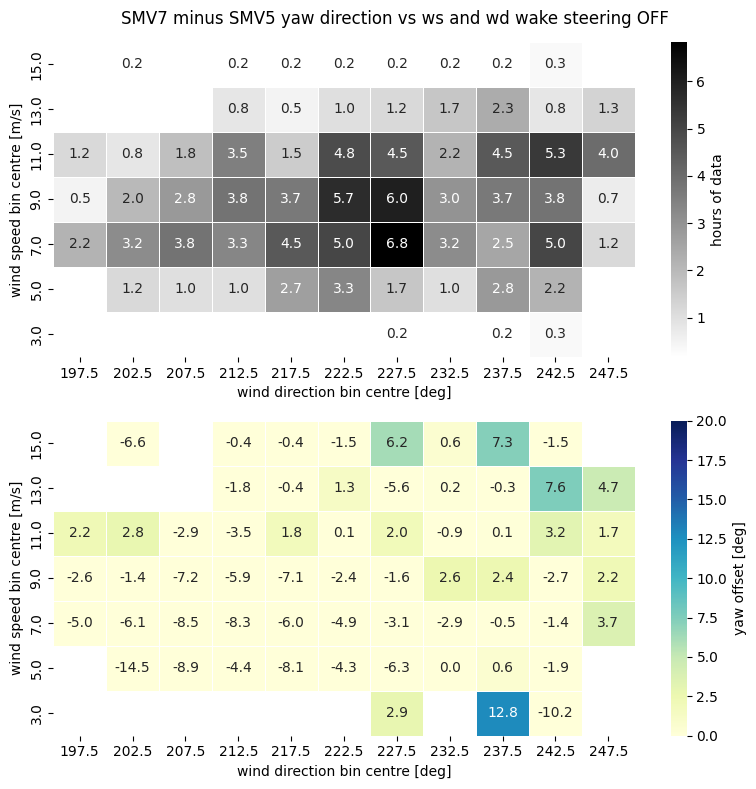

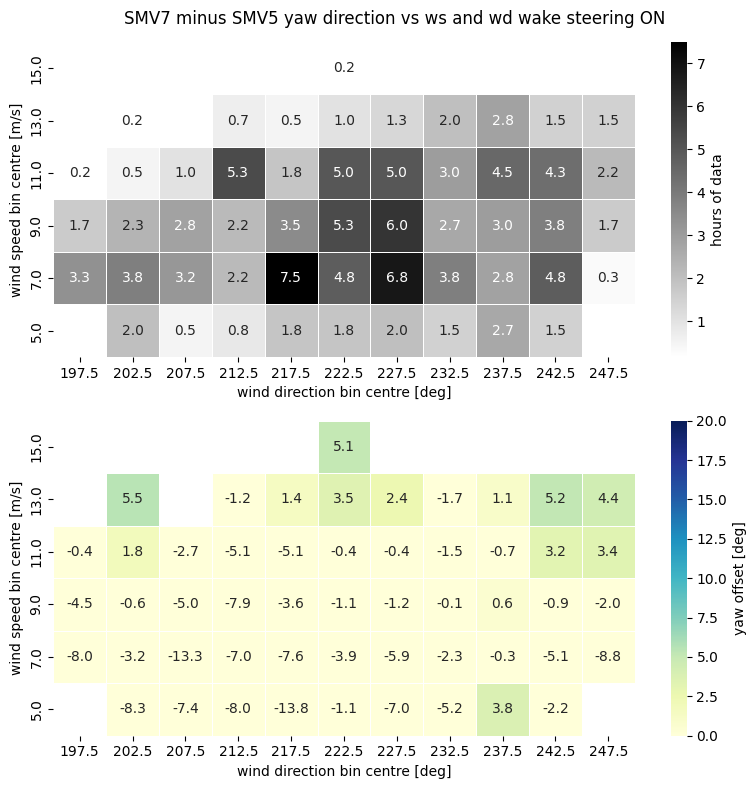

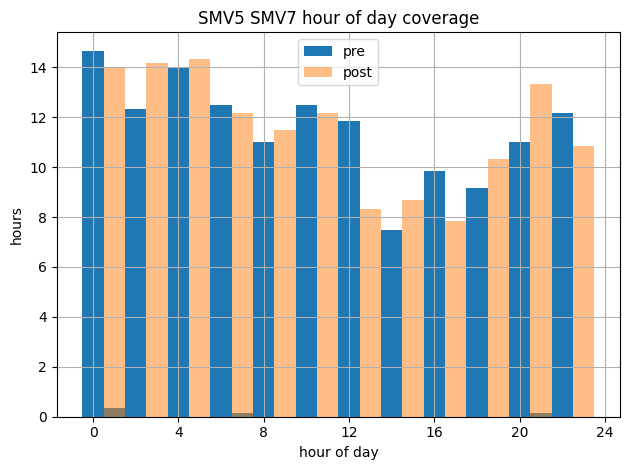

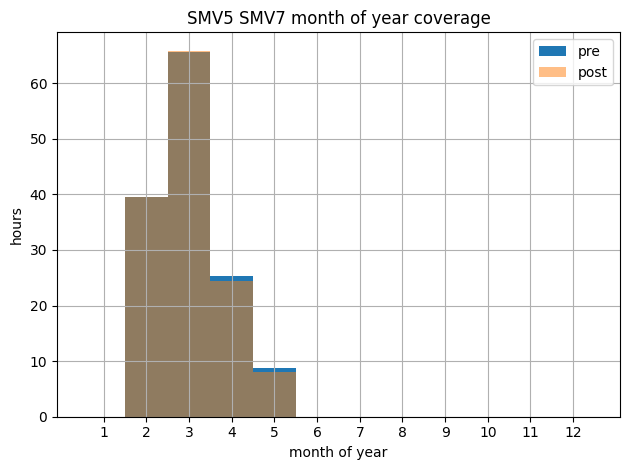

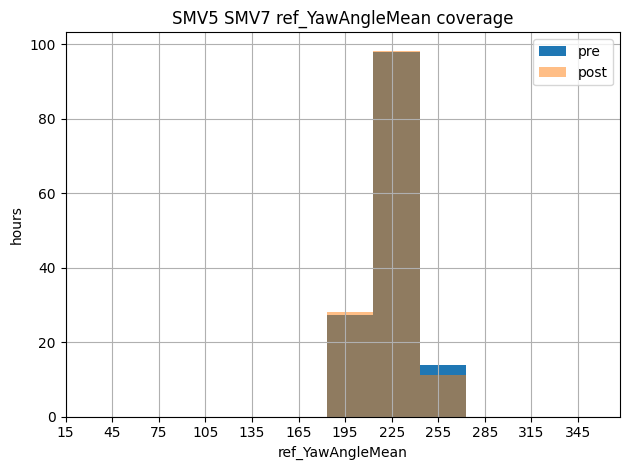

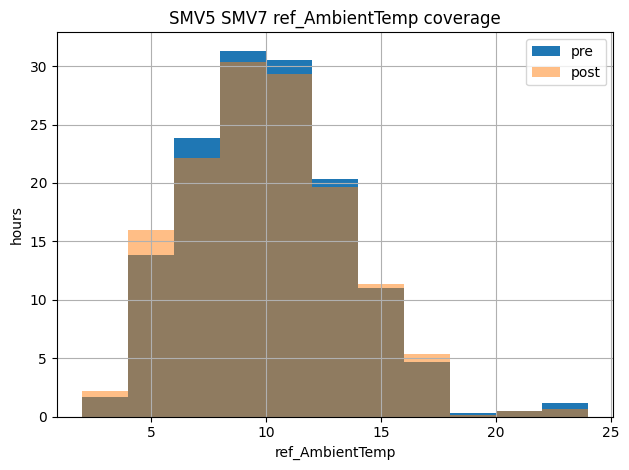

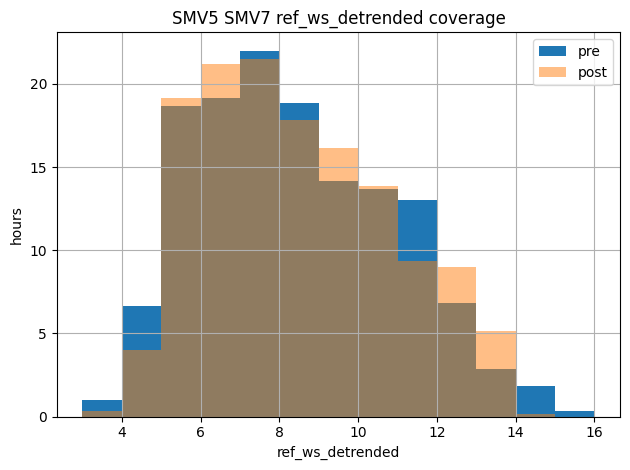

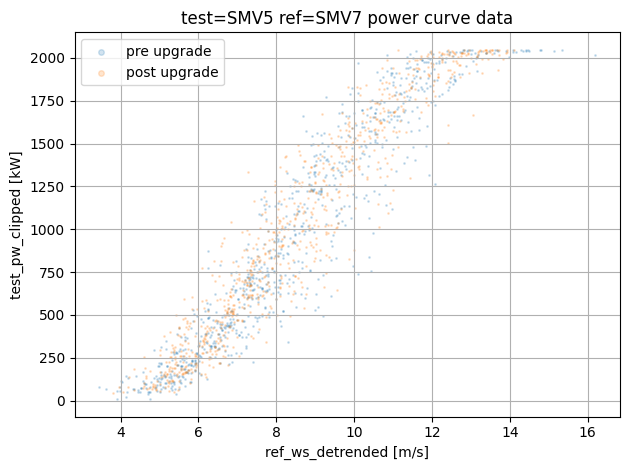

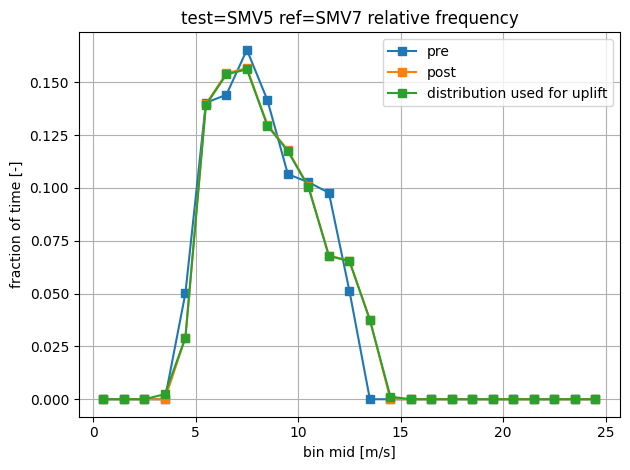

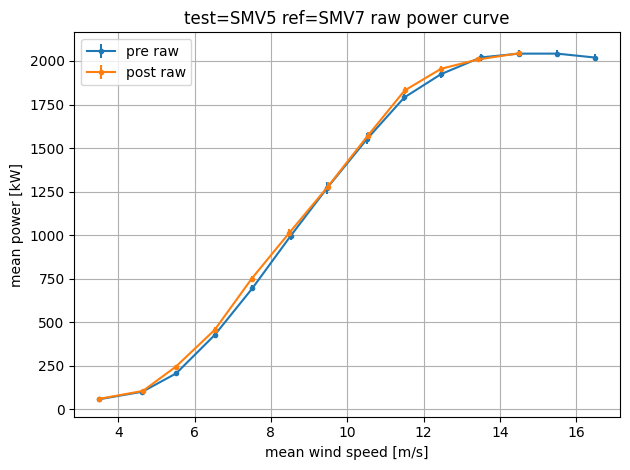

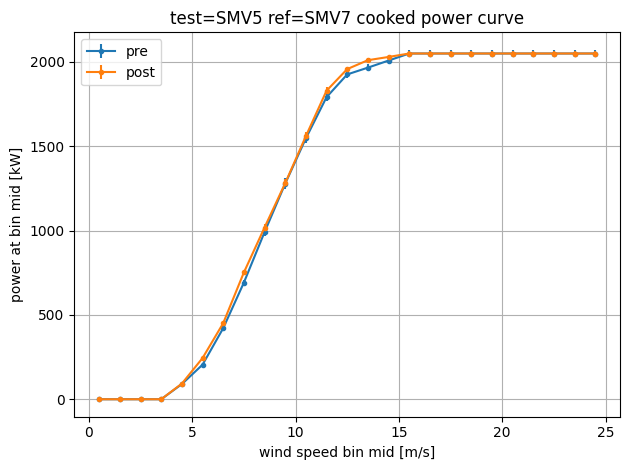

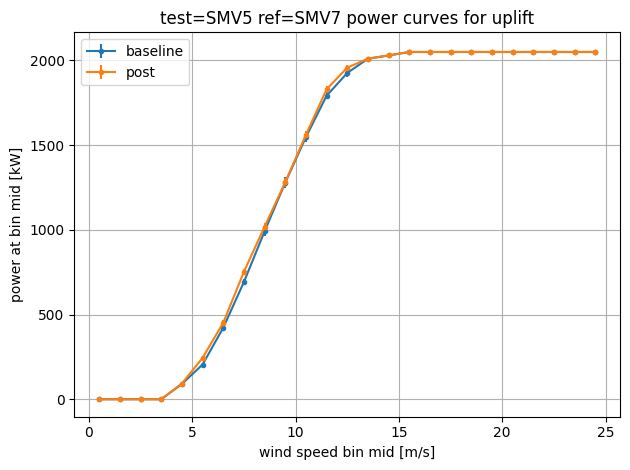

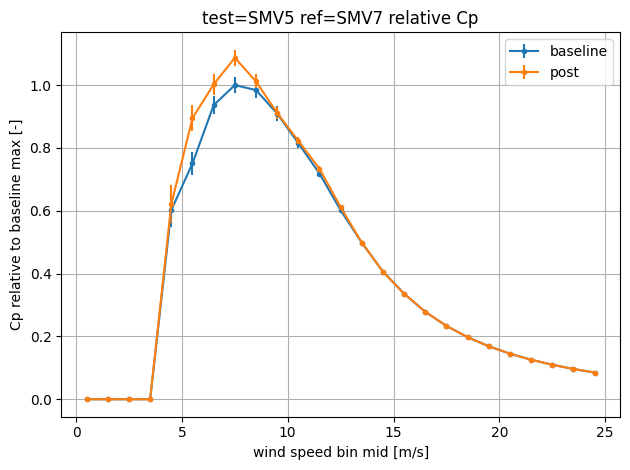

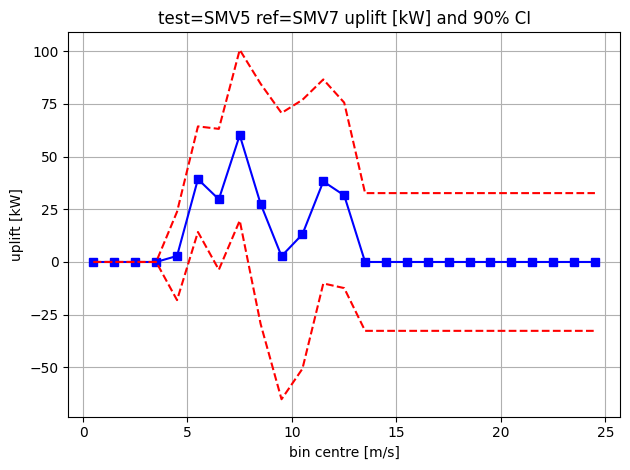

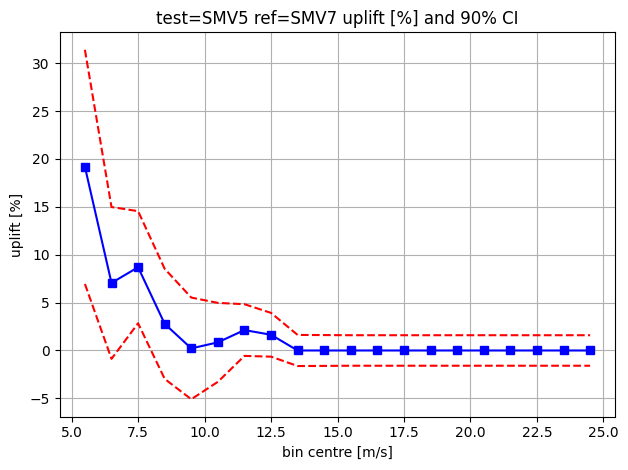

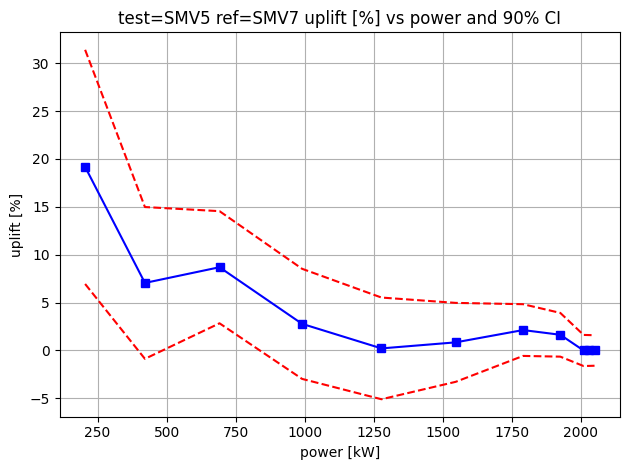

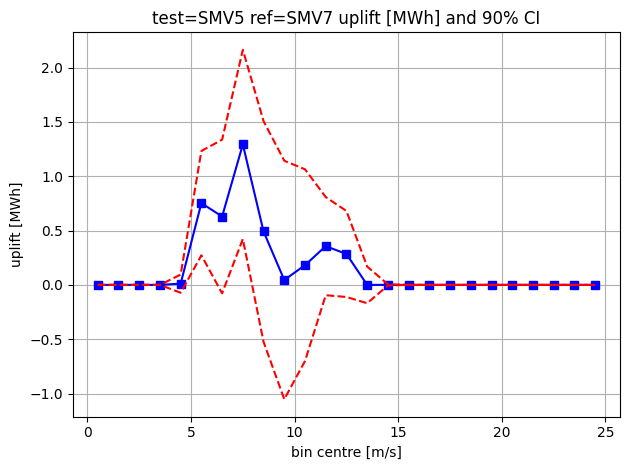

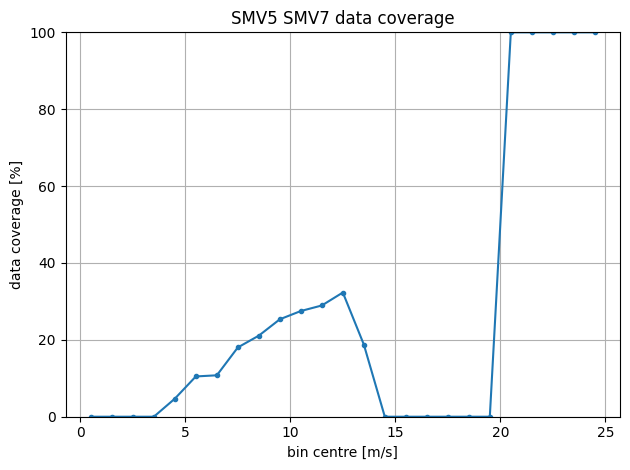


results for test=SMV5 ref=SMV7:

hours pre = 133.0
hours post = 137.2

uplift estimate before adjustments = 3.1 %

power only uplift estimate = 3.0 %
reversed (power only) uplift estimate = 3.1 %

Running block bootstrapping uncertainty analysis n_samples = 400


  0%|          | 0/400 [00:00<?, ?it/s]

block bootstrapping uncertainty analysis results (conf=90%):
  median = 3.1 %
  lower = 1.3 %
  upper = 5.1 %
  unc_one_sigma = 1.2 %

cat A 1 sigma unc = 1.0 %
abs reversal error / 2 = 0.037 %
bootstrap 1 sigma unc = 1.2 %
missing bins scale factor = 1.000
final 1 sigma unc = 1.2 %

final uplift estimate = 3.1 %
final P95 uplift estimate = 1.2 %
final P5 uplift estimate = 5.0 %
{'ref': 'SMV7', 'ref_ws_col': 'ref_ws_est_blend', 'distance_m': 591.1178519927024, 'bearing_deg': 190.23567745705736, 'ref_max_northing_error_v_reanalysis': np.float64(2.673922401887239), 'ref_max_northing_error_v_wf': np.float64(0.0), 'ref_max_ws_drift': np.float64(0.08697706942338845), 'ref_max_ws_drift_pp_period': np.float64(0.08697706942338845), 'ref_powercurve_shift': np.float64(0.003117456887993697), 'ref_rpm_shift': np.float64(0.0015313319638985412), 'ref_pitch_shift': np.float64(-0.05548555519736481), 'detrend_pre_r2_improvement': np.float64(0.09621188863947527), 'detrend_post_r2_improvement': np.float6

CPU times: total: 2min 45s
Wall time: 2min 51s


In [14]:
%%time
from wind_up.main_analysis import run_wind_up_analysis

results_per_test_ref_df = run_wind_up_analysis(assessment_inputs)

In [15]:
from helpers import format_and_print_results_table

format_and_print_results_table(results_per_test_ref_df)

+-----------+-------------+-----------------+----------------------+--------------+-------------+--------------------------+-------------------------+------------------------+
|  turbine  |  reference  |  energy uplift  |  uplift uncertainty  |  uplift P95  |  uplift P5  |  valid hours toggle off  |  valid hours toggle on  |  mean power toggle on  |
+===========+=============+=================+======================+==============+=============+==========================+=========================+========================+
|   SMV6    |    SMV7     |      -1.0%      |         0.6%         |    -2.0%     |    -0.1%    |          132.5           |          136.0          |          1148          |
|   SMV5    |    SMV7     |      3.1%       |         1.2%         |     1.2%     |    5.0%     |          133.0           |          137.2          |          994           |
+-----------+-------------+-----------------+----------------------+--------------+-------------+-----------------------

turbine reference energy uplift uplift uncertainty uplift P95 uplift P5  \
0    SMV6      SMV7         -1.0%               0.6%      -2.0%     -0.1%   
1    SMV5      SMV7          3.1%               1.2%       1.2%      5.0%   

   valid hours toggle off  valid hours toggle on  mean power toggle on  
0                   132.5             136.000000                  1148  
1                   133.0             137.166667                   994

## calculate the net uplift of this wake steering test

For wake steering we expect the steering turbine uplift to be negative and the benefitting turbine uplift to be positive (which are both true in this example). The steering turbine will almost always be more productive than the benefitting turbine since it is usually in a windier (un-waked) location, therefore the % uplift of the benefitting turbine needs to be much higher than the % loss of the steering turbine for the net uplift to be positive. The function below properly calculates the net uplift and combined uncertainty.

In [16]:
from wind_up.combine_results import calc_net_uplift

net_p50, net_p95, net_p5 = calc_net_uplift(results_per_test_ref_df, confidence=0.9)
f"net P50: {net_p50:.1%}, net P95: {net_p95:.1%}, net P5: {net_p5:.1%}"

'net P50: 0.8%, net P95: -0.2%, net P5: 1.9%'